# Event Representations Showcase with evlib

This notebook demonstrates all event representations available in evlib using real event camera data. We'll explore how different representations capture spatiotemporal patterns in event data and their applications in computer vision.

## What are Event Representations?

Event cameras generate asynchronous streams of events, but many algorithms require grid-based representations. Event representations convert sparse event streams into structured formats suitable for:

- **Deep Learning**: Neural networks expect tensor inputs
- **Computer Vision**: Traditional algorithms work on images
- **Analysis**: Understanding temporal and spatial patterns

## Available Representations in evlib

1. **Stacked Histogram** - Temporal binning with polarity separation
2. **Voxel Grid** - 3D spatiotemporal representation with smooth interpolation
3. **Mixed Density Stack** - Spatial distribution with polarity balance
4. **Time Surface** - Exponential decay showing recent activity
5. **Event Histogram** - Simple spatial accumulation
6. **Preprocessing Functions** - Optimized for specific ML models

## Dataset: slider_depth

We'll use the slider_depth dataset which contains:
- **1,078,541 events** recorded during camera motion
- **240×346 pixel resolution**
- **Text format**: timestamp x y polarity
- **Reference frames** for visual context

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import polars as pl
import time
import os
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Import evlib and representations
import evlib
import evlib.representations as evr

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['image.cmap'] = 'viridis'

print(f"evlib version: {evlib.__version__}")
print(f"Polars version: {pl.__version__}")
try:
    print(f"Recommended engine: {evlib.get_recommended_engine()}")
except AttributeError:
    print("Recommended engine: streaming (default for large datasets)")

evlib version: 0.7.18
Polars version: 1.30.0
Recommended engine: streaming (default for large datasets)


## 2. Data Loading and Exploration

In [2]:
# Load the slider_depth dataset
data_path = "../data/slider_depth/events.txt"
print(f"Loading events from: {data_path}")

# Load as LazyFrame for efficient processing
events_lf = evlib.load_events(data_path)

# Get basic statistics
print("\nDataset Statistics:")
print(f"Total events: {events_lf.select(pl.len()).collect().item():,}")

# Sample first 1000 events for quick stats
sample = events_lf.head(1000).collect()
print(f"Columns: {sample.columns}")
print(f"Data types: {sample.dtypes}")

# Time range (convert Duration to seconds for display)
time_stats = events_lf.select([
    pl.col("t").dt.total_seconds().min().alias("t_min"),
    pl.col("t").dt.total_seconds().max().alias("t_max")
]).collect()

duration = time_stats["t_max"].item() - time_stats["t_min"].item()
print(f"Time range: {time_stats['t_min'].item():.3f}s to {time_stats['t_max'].item():.3f}s")
print(f"Duration: {duration:.3f}s")

# Spatial range
spatial_stats = events_lf.select([
    pl.col("x").min().alias("x_min"), pl.col("x").max().alias("x_max"),
    pl.col("y").min().alias("y_min"), pl.col("y").max().alias("y_max")
]).collect()

print(f"Spatial range: x=[{spatial_stats['x_min'].item()}, {spatial_stats['x_max'].item()}], "
      f"y=[{spatial_stats['y_min'].item()}, {spatial_stats['y_max'].item()}]")
print(f"Sensor resolution: {spatial_stats['y_max'].item()+1}×{spatial_stats['x_max'].item()+1}")

# Polarity distribution - handle properly
polarity_stats = events_lf.select(pl.col("polarity").value_counts()).collect()
total_events = events_lf.select(pl.len()).collect().item()

print(f"\nPolarity distribution:")
polarity_data = polarity_stats["polarity"].to_list()
for pol_info in polarity_data:
    pol = pol_info["polarity"]
    count = pol_info["count"]
    percentage = count / total_events * 100
    print(f"  Polarity {pol}: {count:,} events ({percentage:.1f}%)")

Loading events from: ../data/slider_depth/events.txt

Dataset Statistics:
Total events: 1,078,541
Columns: ['x', 'y', 't', 'polarity']
Data types: [Int16, Int16, Duration(time_unit='us'), Int8]
Time range: 0.000s to 3.000s
Duration: 3.000s
Spatial range: x=[0, 239], y=[0, 179]
Sensor resolution: 180×240

Polarity distribution:
  Polarity 1: 447,783 events (41.5%)
  Polarity 0: 630,758 events (58.5%)


### Visualize Raw Event Data

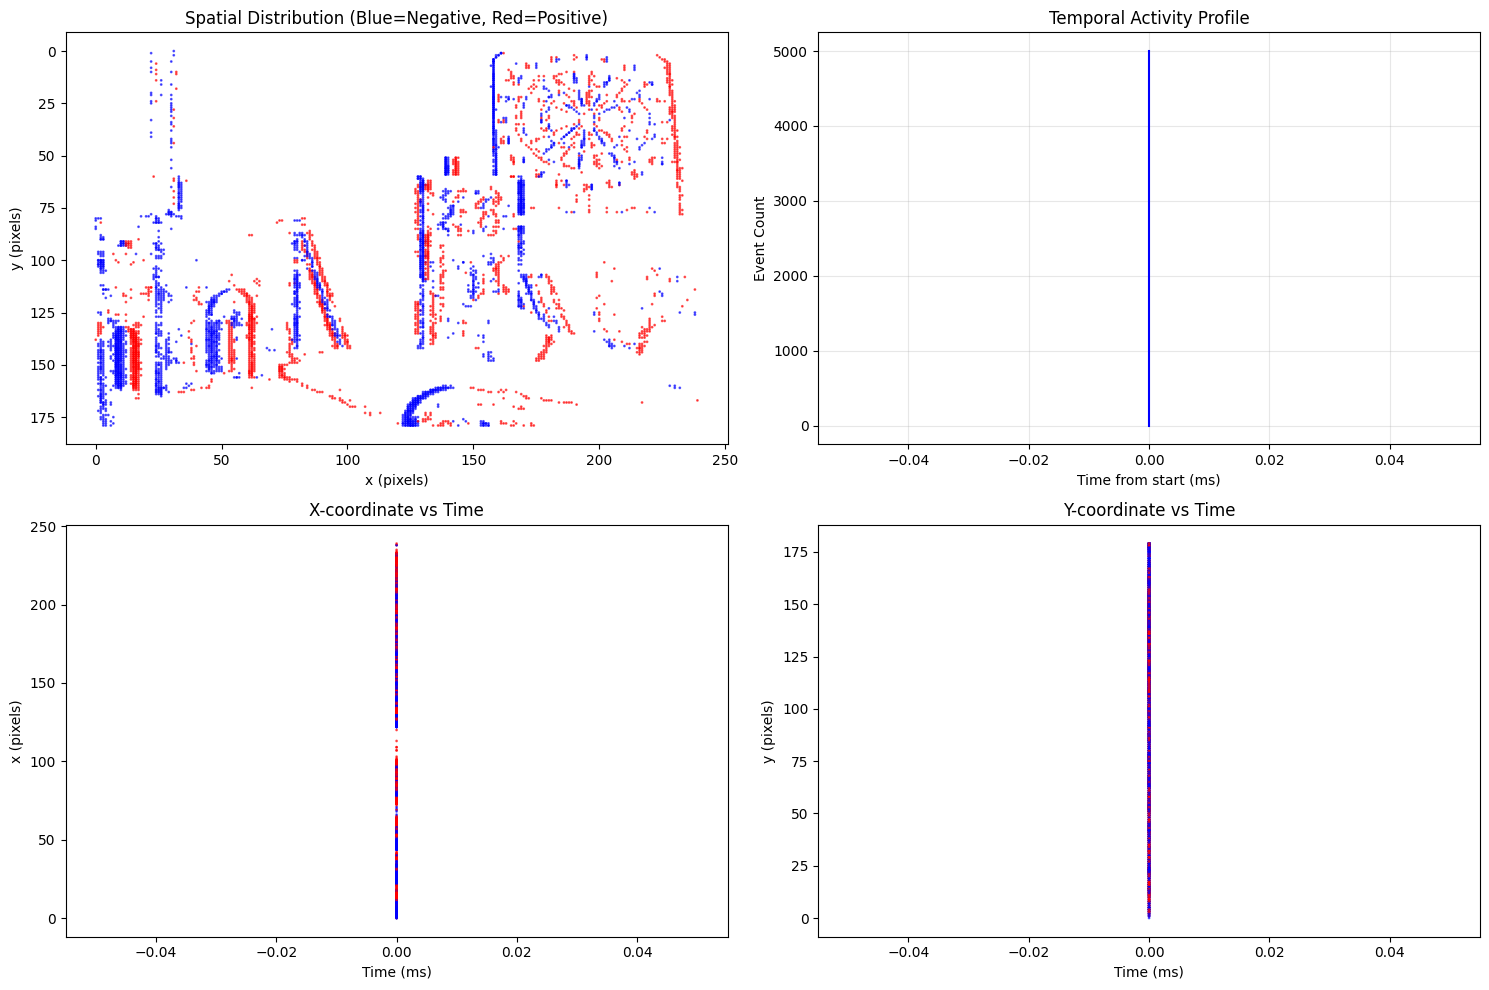

Visualization shows first 5,000 events from the dataset


In [3]:
# Sample events for visualization (use first 5000 for speed)
sample_events = events_lf.head(5000).collect()

# Extract arrays for plotting
x_vals = sample_events["x"].to_numpy()
y_vals = sample_events["y"].to_numpy()
t_vals = sample_events["t"].dt.total_seconds().to_numpy()
pol_vals = sample_events["polarity"].to_numpy()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 2D spatial distribution
colors = ['blue' if p == 0 else 'red' for p in pol_vals]
axes[0, 0].scatter(x_vals, y_vals, c=colors, alpha=0.6, s=1)
axes[0, 0].set_xlabel('x (pixels)')
axes[0, 0].set_ylabel('y (pixels)')
axes[0, 0].set_title('Spatial Distribution (Blue=Negative, Red=Positive)')
axes[0, 0].invert_yaxis()  # Match image coordinates

# Temporal activity
time_bins = np.linspace(t_vals.min(), t_vals.max(), 50)
counts, _ = np.histogram(t_vals, bins=time_bins)
axes[0, 1].plot((time_bins[1:] - t_vals.min()) * 1000, counts, 'b-', linewidth=1.5)
axes[0, 1].set_xlabel('Time from start (ms)')
axes[0, 1].set_ylabel('Event Count')
axes[0, 1].set_title('Temporal Activity Profile')
axes[0, 1].grid(True, alpha=0.3)

# X-coordinate distribution over time
axes[1, 0].scatter(t_vals * 1000, x_vals, c=colors, alpha=0.6, s=1)
axes[1, 0].set_xlabel('Time (ms)')
axes[1, 0].set_ylabel('x (pixels)')
axes[1, 0].set_title('X-coordinate vs Time')

# Y-coordinate distribution over time
axes[1, 1].scatter(t_vals * 1000, y_vals, c=colors, alpha=0.6, s=1)
axes[1, 1].set_xlabel('Time (ms)')
axes[1, 1].set_ylabel('y (pixels)')
axes[1, 1].set_title('Y-coordinate vs Time')

plt.tight_layout()
plt.show()

print(f"Visualization shows first {len(sample_events):,} events from the dataset")

### 3D Spatiotemporal Visualization

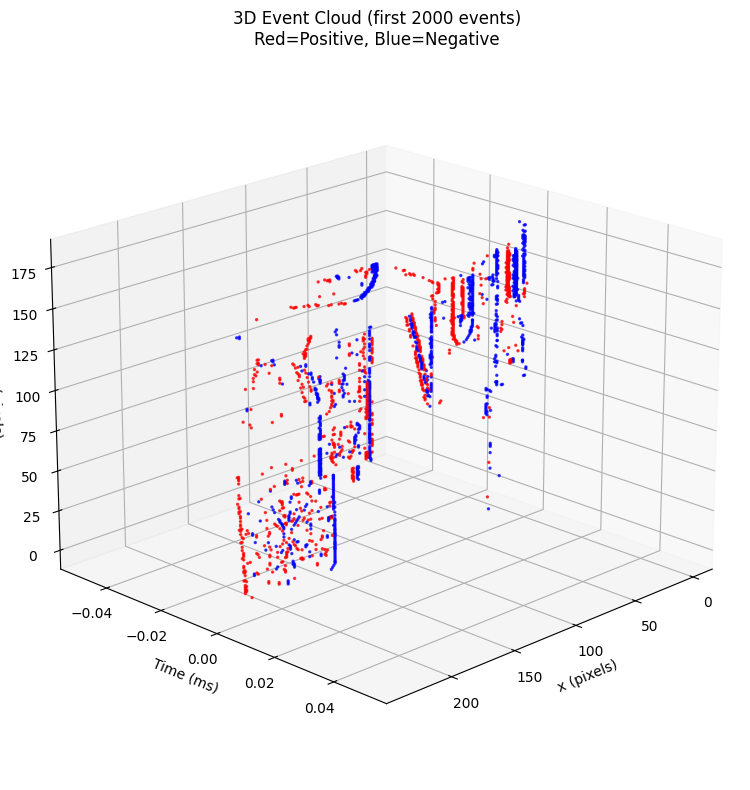

3D visualization reveals the spatiotemporal structure of event data
Events cluster in space and time, showing the camera motion and scene structure


In [6]:
# 3D visualization with fewer points for clarity
n_3d = 2000
sample_3d = sample_events.head(n_3d)

x_3d = sample_3d["x"].to_numpy()
y_3d = sample_3d["y"].to_numpy()
t_3d = sample_3d["t"].dt.total_seconds().to_numpy()
pol_3d = sample_3d["polarity"].to_numpy()

# Normalize time for better visualization
t_3d_norm = (t_3d - t_3d[0]) * 1000  # Convert to milliseconds from start

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Color by polarity
colors_3d = ['blue' if p == 0 else 'red' for p in pol_3d]
scatter = ax.scatter(x_3d, t_3d_norm, y_3d, c=colors_3d, alpha=0.7, s=2)

ax.set_xlabel('x (pixels)')
ax.set_ylabel('Time (ms)')
ax.set_zlabel('y (pixels)')
ax.set_title(f'3D Event Cloud (first {n_3d} events)\nRed=Positive, Blue=Negative')
ax.view_init(azim=45, elev=20)

plt.tight_layout()
plt.show()

print("3D visualization reveals the spatiotemporal structure of event data")
print("Events cluster in space and time, showing the camera motion and scene structure")

## 3. Individual Event Representations

Now we'll demonstrate each representation available in evlib. We'll use a manageable time window for efficient computation and clear visualization.

In [7]:
# Define common parameters for all representations
HEIGHT = 240
WIDTH = 346
ENGINE = "streaming"  # Use streaming for large datasets

# Use first 100ms of data for representations (manageable size)
start_time = events_lf.select(pl.col("t").dt.total_seconds().min()).collect().item()
time_window = start_time + 0.1  # 100ms window

# Filter events to time window
events_window = events_lf.filter(
    pl.col("t").dt.total_seconds() <= time_window
)

n_events_window = events_window.select(pl.len()).collect().item()
print(f"Using first {n_events_window:,} events (first 100ms) for representations")
print(f"Time range: {start_time:.3f}s to {time_window:.3f}s")

Using first 311,110 events (first 100ms) for representations
Time range: 0.000s to 0.100s


### 3.1 Stacked Histogram

Creating Stacked Histogram...
Creation time: 0.017s
5-bin histogram shape: 22528 rows
10-bin histogram shape: 25177 rows
Columns: ['time_bin', 'polarity', 'y', 'x', 'count']


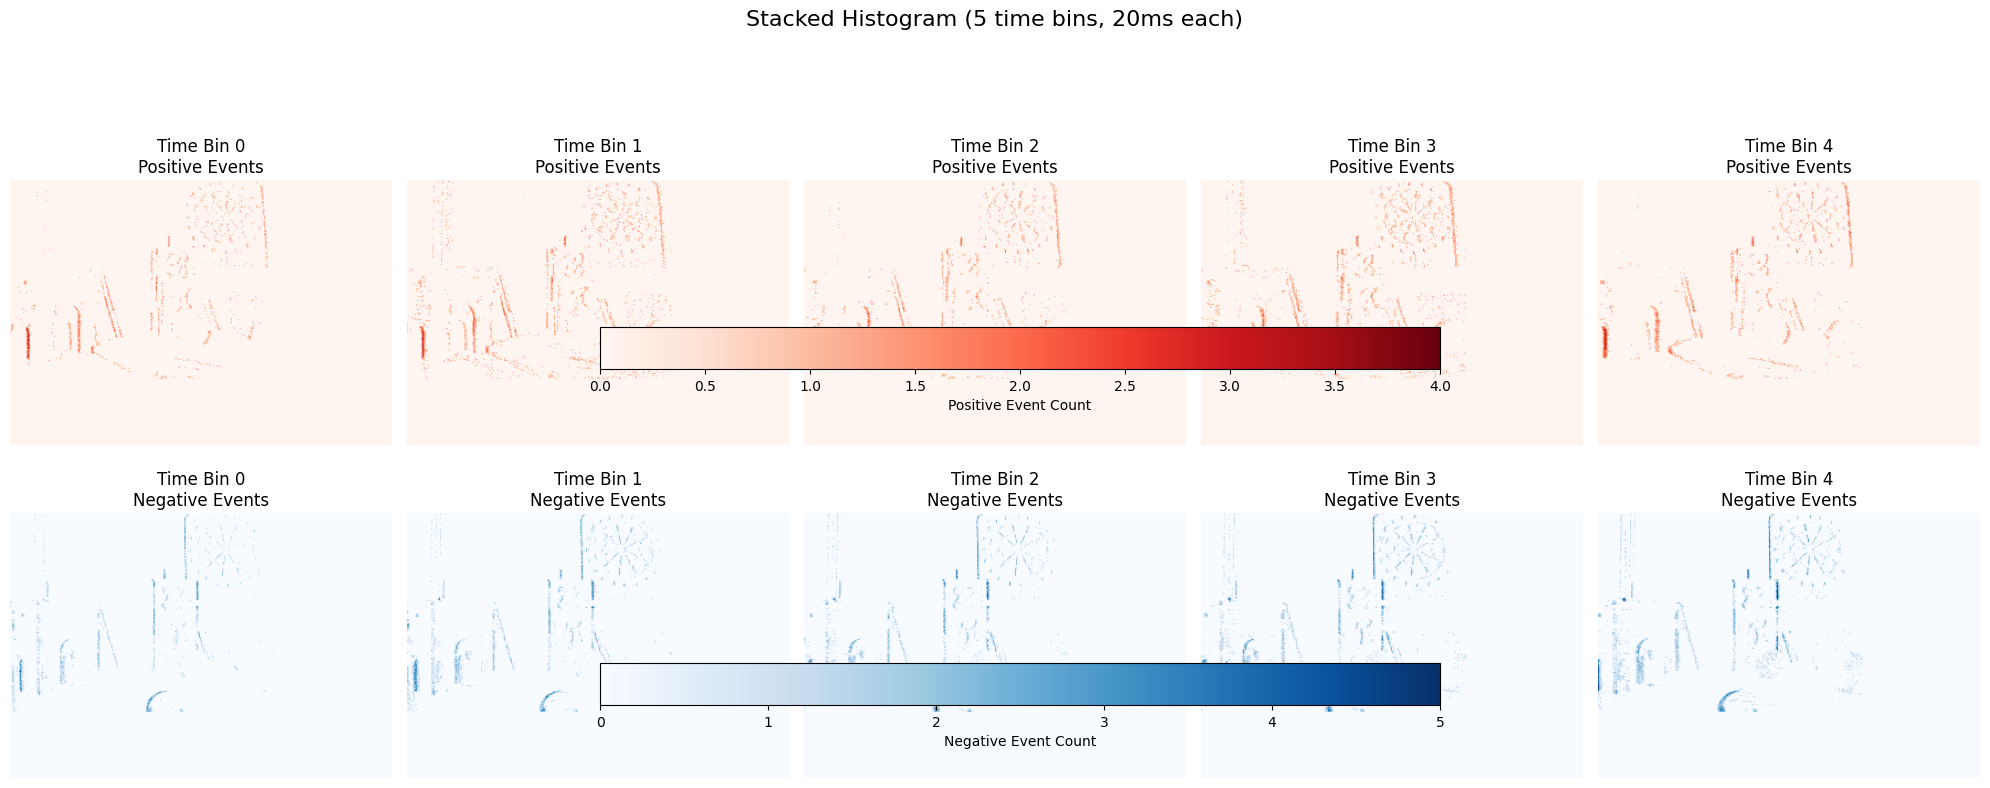

Stacked histograms show how events accumulate in temporal bins
Each time bin captures event activity during that time period
Use case: Input to deep learning models (RVT, E2VID, etc.)


In [8]:
print("Creating Stacked Histogram...")
start_time_rep = time.time()

# Create stacked histogram with different bin configurations
hist_5_df = evr.create_stacked_histogram(
    events_window, HEIGHT, WIDTH, bins=5, window_duration_ms=20.0, engine=ENGINE
)
hist_10_df = evr.create_stacked_histogram(
    events_window, HEIGHT, WIDTH, bins=10, window_duration_ms=10.0, engine=ENGINE
)

creation_time = time.time() - start_time_rep
print(f"Creation time: {creation_time:.3f}s")
print(f"5-bin histogram shape: {len(hist_5_df)} rows")
print(f"10-bin histogram shape: {len(hist_10_df)} rows")
print(f"Columns: {hist_5_df.columns}")

# Convert to dense arrays for visualization
def histogram_to_array(hist_df, height, width, bins):
    """Convert histogram DataFrame to dense array for visualization."""
    # Create separate arrays for each polarity
    pos_array = np.zeros((bins, height, width))
    neg_array = np.zeros((bins, height, width))
    
    for row in hist_df.iter_rows(named=True):
        time_bin = row['time_bin']
        y, x = row['y'], row['x']
        count = row['count']
        polarity = row['polarity']
        
        if 0 <= time_bin < bins and 0 <= y < height and 0 <= x < width:
            if polarity == 1:
                pos_array[time_bin, y, x] = count
            else:
                neg_array[time_bin, y, x] = count
    
    return pos_array, neg_array

pos_hist_5, neg_hist_5 = histogram_to_array(hist_5_df, HEIGHT, WIDTH, 5)

# Visualize stacked histogram
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Stacked Histogram (5 time bins, 20ms each)', fontsize=16)

for i in range(5):
    # Positive events
    im1 = axes[0, i].imshow(pos_hist_5[i], cmap='Reds', vmin=0, vmax=pos_hist_5.max())
    axes[0, i].set_title(f'Time Bin {i}\nPositive Events')
    axes[0, i].axis('off')
    
    # Negative events
    im2 = axes[1, i].imshow(neg_hist_5[i], cmap='Blues', vmin=0, vmax=neg_hist_5.max())
    axes[1, i].set_title(f'Time Bin {i}\nNegative Events')
    axes[1, i].axis('off')

# Add colorbars
plt.colorbar(im1, ax=axes[0, :], orientation='horizontal', label='Positive Event Count', shrink=0.6)
plt.colorbar(im2, ax=axes[1, :], orientation='horizontal', label='Negative Event Count', shrink=0.6)

plt.tight_layout()
plt.show()

print("Stacked histograms show how events accumulate in temporal bins")
print("Each time bin captures event activity during that time period")
print("Use case: Input to deep learning models (RVT, E2VID, etc.)")

### 3.2 Voxel Grid

Creating Voxel Grid...
Creation time: 0.010s
Voxel grid shape: 311108 rows
Columns: ['x', 'y', 'time_bin', 'contribution']
Contribution range: [0.000, 1.000]


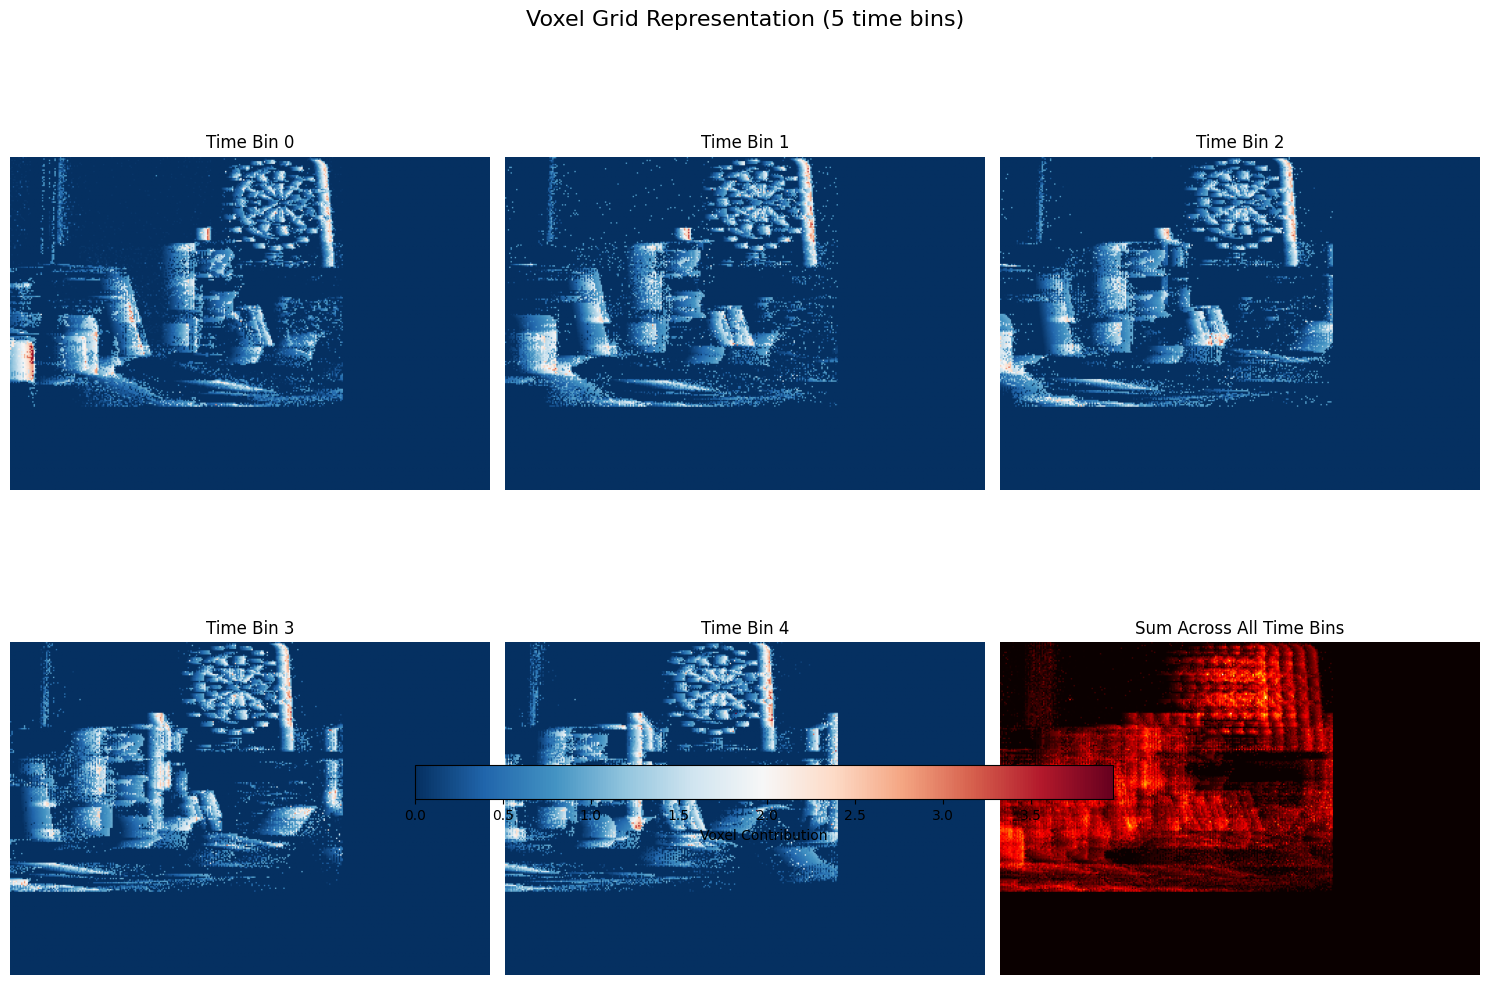

Voxel grids use bilinear interpolation for smooth temporal transitions
Each voxel contains weighted contributions from nearby events
Use case: Smooth spatiotemporal representations for neural networks


In [9]:
print("Creating Voxel Grid...")
start_time_rep = time.time()

# Create voxel grid
voxel_df = evr.create_voxel_grid(
    events_window, HEIGHT, WIDTH, n_time_bins=5, engine=ENGINE
)

creation_time = time.time() - start_time_rep
print(f"Creation time: {creation_time:.3f}s")
print(f"Voxel grid shape: {len(voxel_df)} rows")
print(f"Columns: {voxel_df.columns}")
print(f"Contribution range: [{voxel_df['contribution'].min():.3f}, {voxel_df['contribution'].max():.3f}]")

# Convert to dense array
def voxel_to_array(voxel_df, height, width, n_bins):
    """Convert voxel DataFrame to dense array."""
    voxel_array = np.zeros((n_bins, height, width))
    
    for row in voxel_df.iter_rows(named=True):
        time_bin = row['time_bin']
        y, x = row['y'], row['x']
        contribution = row['contribution']
        
        if 0 <= time_bin < n_bins and 0 <= y < height and 0 <= x < width:
            voxel_array[time_bin, y, x] += contribution
    
    return voxel_array

voxel_array = voxel_to_array(voxel_df, HEIGHT, WIDTH, 5)

# Visualize voxel grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Voxel Grid Representation (5 time bins)', fontsize=16)

# Show individual time slices
for i in range(5):
    row = i // 3
    col = i % 3
    if row < 2 and col < 3:
        im = axes[row, col].imshow(voxel_array[i], cmap='RdBu_r', 
                                  vmin=voxel_array.min(), vmax=voxel_array.max())
        axes[row, col].set_title(f'Time Bin {i}')
        axes[row, col].axis('off')

# Sum across all time bins
axes[1, 2].imshow(voxel_array.sum(axis=0), cmap='hot')
axes[1, 2].set_title('Sum Across All Time Bins')
axes[1, 2].axis('off')

plt.colorbar(im, ax=axes, orientation='horizontal', label='Voxel Contribution', shrink=0.6)
plt.tight_layout()
plt.show()

print("Voxel grids use bilinear interpolation for smooth temporal transitions")
print("Each voxel contains weighted contributions from nearby events")
print("Use case: Smooth spatiotemporal representations for neural networks")

### 3.3 Mixed Density Stack

Creating Mixed Density Stack...
Creation time: 0.018s
Mixed density shape: 37818 rows
Columns: ['x', 'y', 'polarity_sum', 'count']


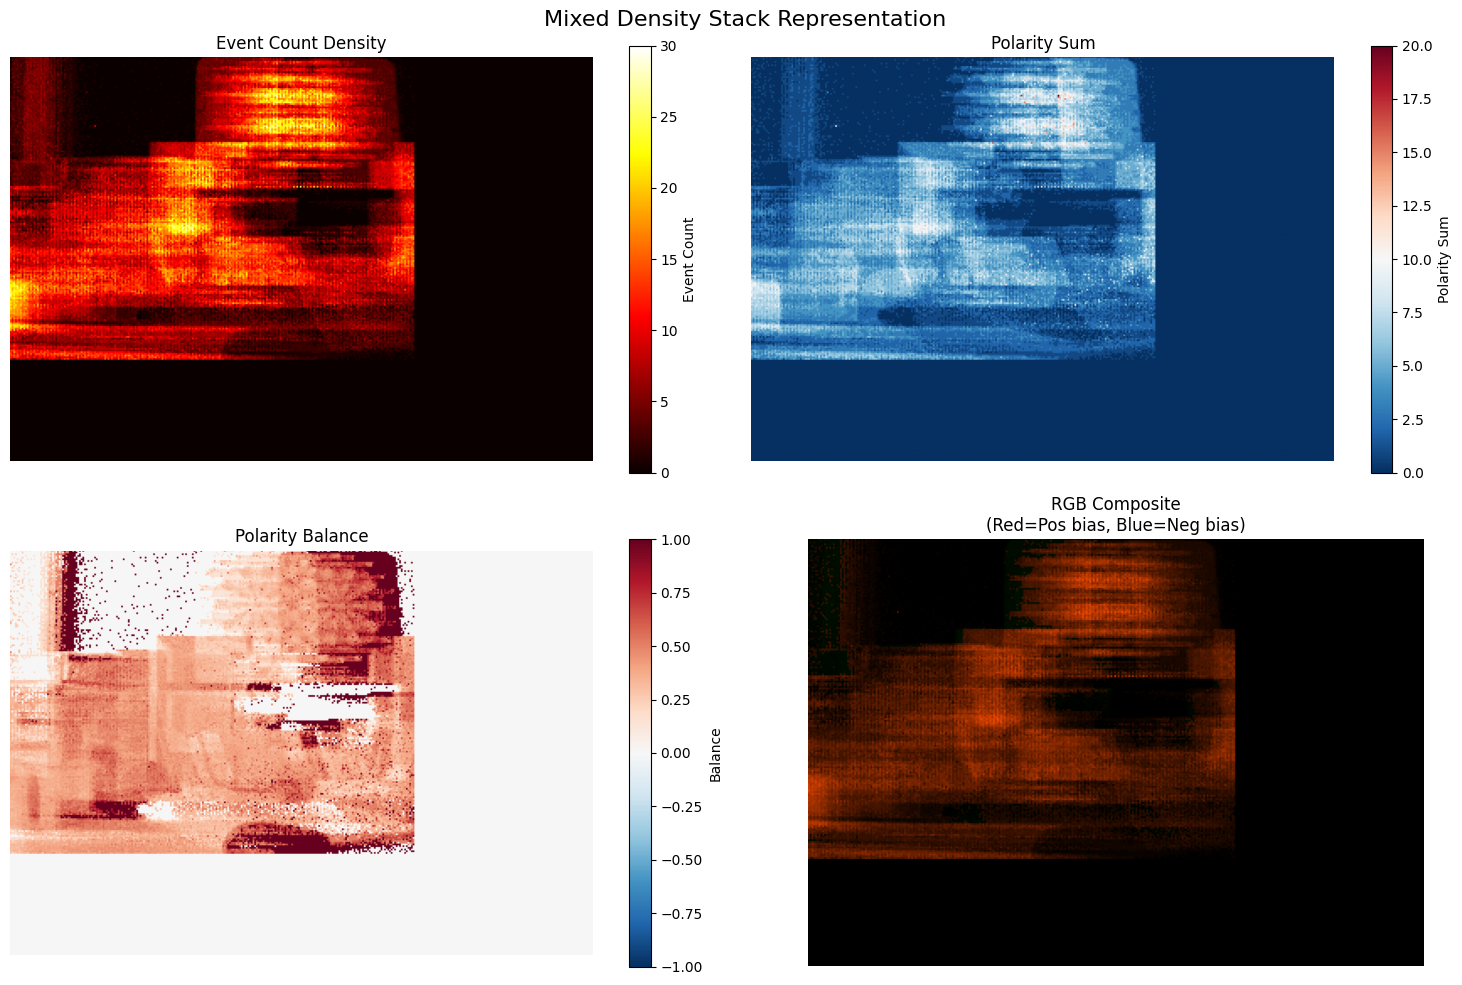

Mixed density stacks combine spatial distribution with polarity information
Shows both where events occur and their polarity balance
Use case: Spatial analysis, noise reduction, edge detection


In [10]:
print("Creating Mixed Density Stack...")
start_time_rep = time.time()

# Create mixed density stack
mixed_df = evr.create_mixed_density_stack(
    events_window, HEIGHT, WIDTH, engine=ENGINE
)

creation_time = time.time() - start_time_rep
print(f"Creation time: {creation_time:.3f}s")
print(f"Mixed density shape: {len(mixed_df)} rows")
print(f"Columns: {mixed_df.columns}")

# Convert to arrays
polarity_sum_array = np.zeros((HEIGHT, WIDTH))
count_array = np.zeros((HEIGHT, WIDTH))

for row in mixed_df.iter_rows(named=True):
    y, x = row['y'], row['x']
    if 0 <= y < HEIGHT and 0 <= x < WIDTH:
        polarity_sum_array[y, x] = row['polarity_sum']
        count_array[y, x] = row['count']

# Create balance array (normalized polarity)
balance_array = np.zeros_like(polarity_sum_array)
mask = count_array > 0
balance_array[mask] = polarity_sum_array[mask] / count_array[mask]

# Visualize mixed density stack
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Mixed Density Stack Representation', fontsize=16)

# Event count density
im1 = axes[0, 0].imshow(count_array, cmap='hot')
axes[0, 0].set_title('Event Count Density')
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], label='Event Count')

# Polarity sum
im2 = axes[0, 1].imshow(polarity_sum_array, cmap='RdBu_r', 
                        vmin=polarity_sum_array.min(), vmax=polarity_sum_array.max())
axes[0, 1].set_title('Polarity Sum')
axes[0, 1].axis('off')
plt.colorbar(im2, ax=axes[0, 1], label='Polarity Sum')

# Polarity balance
im3 = axes[1, 0].imshow(balance_array, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 0].set_title('Polarity Balance')
axes[1, 0].axis('off')
plt.colorbar(im3, ax=axes[1, 0], label='Balance')

# Combined visualization (RGB)
rgb_image = np.zeros((HEIGHT, WIDTH, 3))
# Normalize for RGB display
count_norm = count_array / count_array.max() if count_array.max() > 0 else count_array
balance_norm = (balance_array + 1) / 2  # Map [-1, 1] to [0, 1]

rgb_image[:, :, 0] = count_norm * (balance_norm > 0.5)  # Red for positive bias
rgb_image[:, :, 2] = count_norm * (balance_norm < 0.5)  # Blue for negative bias
rgb_image[:, :, 1] = count_norm * 0.3  # Green for overall activity

axes[1, 1].imshow(rgb_image)
axes[1, 1].set_title('RGB Composite\n(Red=Pos bias, Blue=Neg bias)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("Mixed density stacks combine spatial distribution with polarity information")
print("Shows both where events occur and their polarity balance")
print("Use case: Spatial analysis, noise reduction, edge detection")

### 3.4 Time Surface

Creating Time Surface...
Creation time: 0.017s
Time surface shape: 68954 rows
Columns: ['x', 'y', 'polarity', 'last_timestamp', 'event_count', 'surface_value']


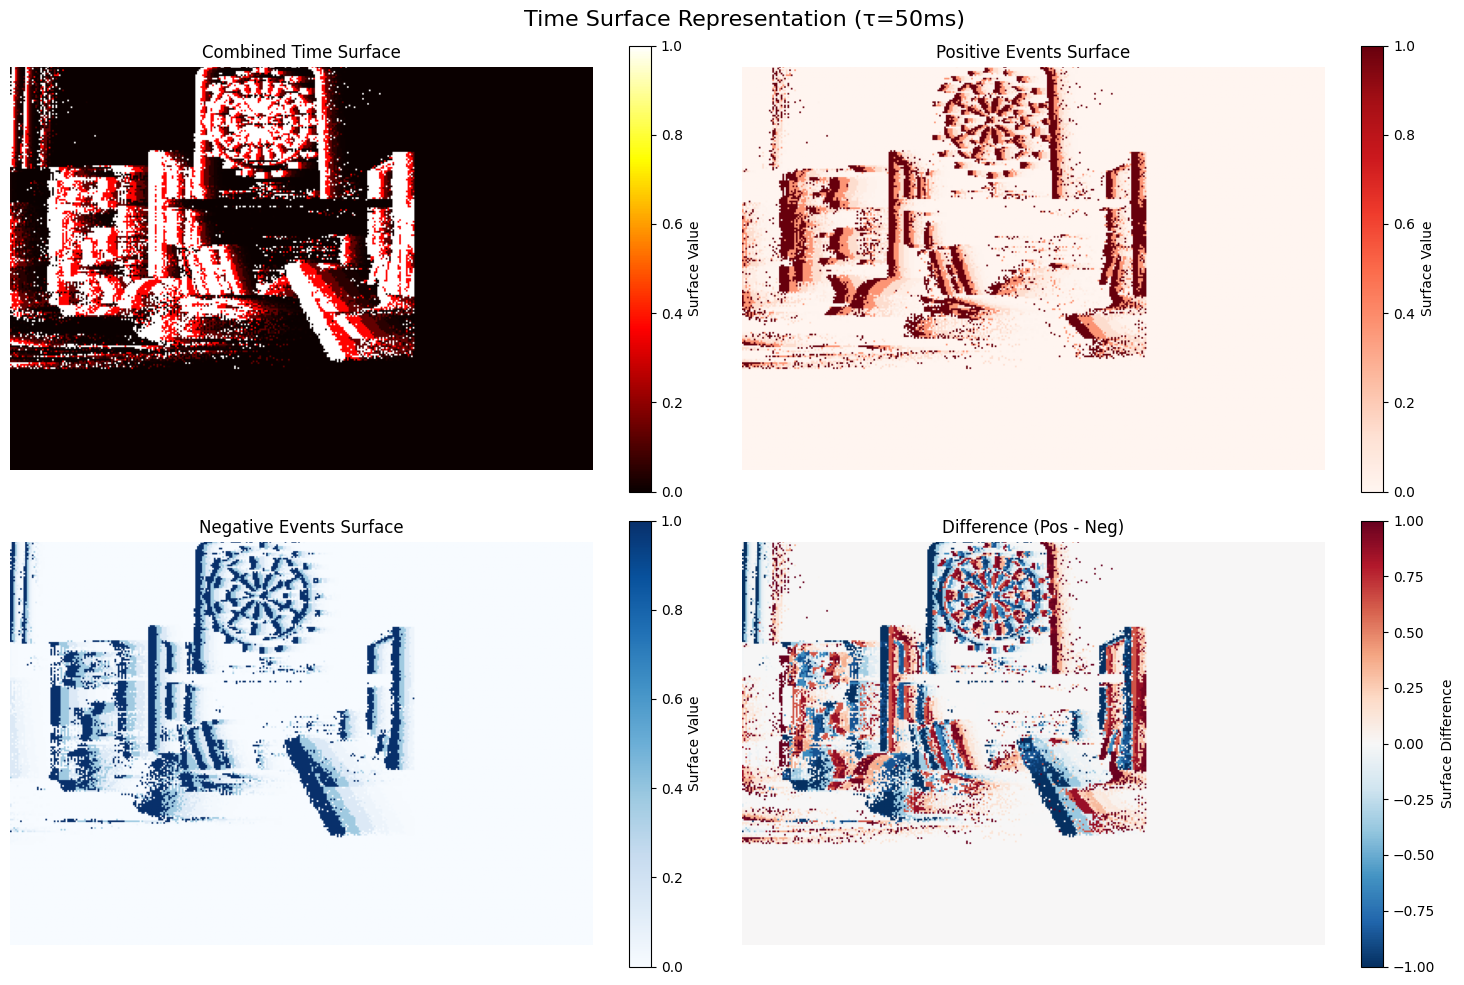

Time surfaces show exponential decay from last event timestamp
Bright pixels indicate recent activity, dark pixels show older or no activity
Use case: Temporal context, activity-based filtering, motion detection


In [11]:
print("Creating Time Surface...")
start_time_rep = time.time()

# Create time surface with different time constants
time_surface_df = evr.time_surface(
    events_window, HEIGHT, WIDTH, tau=50000.0, engine=ENGINE  # 50ms time constant
)

creation_time = time.time() - start_time_rep
print(f"Creation time: {creation_time:.3f}s")
print(f"Time surface shape: {len(time_surface_df)} rows")
print(f"Columns: {time_surface_df.columns}")

# Convert to arrays
time_surface_combined = np.zeros((HEIGHT, WIDTH))
time_surface_pos = np.zeros((HEIGHT, WIDTH))
time_surface_neg = np.zeros((HEIGHT, WIDTH))

for row in time_surface_df.iter_rows(named=True):
    y, x = row['y'], row['x']
    polarity = row['polarity']
    surface_value = row['surface_value']
    
    if 0 <= y < HEIGHT and 0 <= x < WIDTH:
        # Combined surface
        time_surface_combined[y, x] = max(time_surface_combined[y, x], surface_value)
        
        # Polarity-specific surfaces
        if polarity == 1:
            time_surface_pos[y, x] = surface_value
        else:
            time_surface_neg[y, x] = surface_value

# Visualize time surface
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Time Surface Representation (τ=50ms)', fontsize=16)

# Combined surface
im1 = axes[0, 0].imshow(time_surface_combined, cmap='hot', vmin=0, vmax=1)
axes[0, 0].set_title('Combined Time Surface')
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], label='Surface Value')

# Positive events surface
im2 = axes[0, 1].imshow(time_surface_pos, cmap='Reds', vmin=0, vmax=1)
axes[0, 1].set_title('Positive Events Surface')
axes[0, 1].axis('off')
plt.colorbar(im2, ax=axes[0, 1], label='Surface Value')

# Negative events surface
im3 = axes[1, 0].imshow(time_surface_neg, cmap='Blues', vmin=0, vmax=1)
axes[1, 0].set_title('Negative Events Surface')
axes[1, 0].axis('off')
plt.colorbar(im3, ax=axes[1, 0], label='Surface Value')

# Difference surface
diff_surface = time_surface_pos - time_surface_neg
im4 = axes[1, 1].imshow(diff_surface, cmap='RdBu_r', 
                        vmin=diff_surface.min(), vmax=diff_surface.max())
axes[1, 1].set_title('Difference (Pos - Neg)')
axes[1, 1].axis('off')
plt.colorbar(im4, ax=axes[1, 1], label='Surface Difference')

plt.tight_layout()
plt.show()

print("Time surfaces show exponential decay from last event timestamp")
print("Bright pixels indicate recent activity, dark pixels show older or no activity")
print("Use case: Temporal context, activity-based filtering, motion detection")

### 3.5 Event Histogram

Creating Event Histogram...
Creation time: 0.013s
Event histogram shape: 68954 rows
Columns: ['x', 'y', 'polarity', 'count', 'polarity_sum']
Total events: 311,110
Active pixels: 37,818 / 83,040 (45.542%)
Max events per pixel: 30


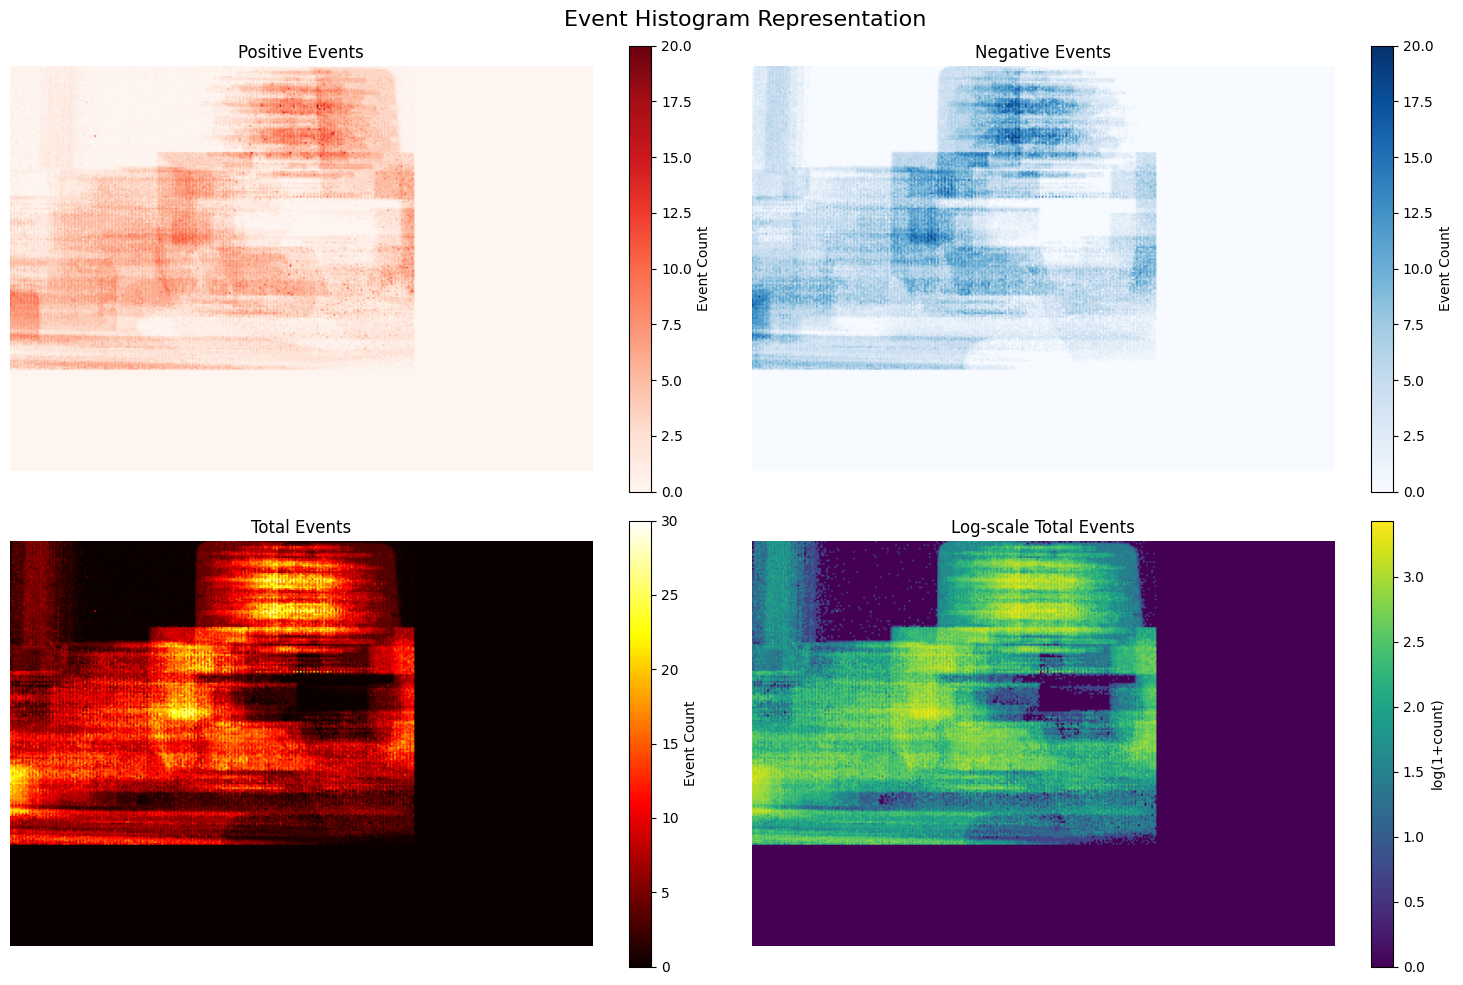

Event histograms provide simple spatial accumulation of events
Shows where activity occurs without temporal information
Use case: Basic spatial analysis, activity maps, preprocessing


In [12]:
print("Creating Event Histogram...")
start_time_rep = time.time()

# Create simple event histogram
event_hist_df = evr.event_histogram(
    events_window, HEIGHT, WIDTH, engine=ENGINE
)

creation_time = time.time() - start_time_rep
print(f"Creation time: {creation_time:.3f}s")
print(f"Event histogram shape: {len(event_hist_df)} rows")
print(f"Columns: {event_hist_df.columns}")

# Convert to arrays
event_count_pos = np.zeros((HEIGHT, WIDTH))
event_count_neg = np.zeros((HEIGHT, WIDTH))
event_count_total = np.zeros((HEIGHT, WIDTH))

for row in event_hist_df.iter_rows(named=True):
    y, x = row['y'], row['x']
    polarity = row['polarity']
    count = row['count']
    
    if 0 <= y < HEIGHT and 0 <= x < WIDTH:
        if polarity == 1:
            event_count_pos[y, x] = count
        else:
            event_count_neg[y, x] = count
        event_count_total[y, x] += count

# Calculate statistics
total_events = event_count_total.sum()
active_pixels = np.sum(event_count_total > 0)
sparsity = active_pixels / (HEIGHT * WIDTH)

print(f"Total events: {int(total_events):,}")
print(f"Active pixels: {active_pixels:,} / {HEIGHT * WIDTH:,} ({sparsity:.3%})")
print(f"Max events per pixel: {int(event_count_total.max())}")

# Visualize event histogram
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Event Histogram Representation', fontsize=16)

# Positive events
im1 = axes[0, 0].imshow(event_count_pos, cmap='Reds')
axes[0, 0].set_title('Positive Events')
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], label='Event Count')

# Negative events
im2 = axes[0, 1].imshow(event_count_neg, cmap='Blues')
axes[0, 1].set_title('Negative Events')
axes[0, 1].axis('off')
plt.colorbar(im2, ax=axes[0, 1], label='Event Count')

# Total events
im3 = axes[1, 0].imshow(event_count_total, cmap='hot')
axes[1, 0].set_title('Total Events')
axes[1, 0].axis('off')
plt.colorbar(im3, ax=axes[1, 0], label='Event Count')

# Log-scale visualization
log_counts = np.log1p(event_count_total)  # log(1+x) to handle zeros
im4 = axes[1, 1].imshow(log_counts, cmap='viridis')
axes[1, 1].set_title('Log-scale Total Events')
axes[1, 1].axis('off')
plt.colorbar(im4, ax=axes[1, 1], label='log(1+count)')

plt.tight_layout()
plt.show()

print("Event histograms provide simple spatial accumulation of events")
print("Shows where activity occurs without temporal information")
print("Use case: Basic spatial analysis, activity maps, preprocessing")

### 3.6 Preprocessing Functions

Creating Preprocessing Representations...
Creation time: 0.059s
Detection preprocessing shape: 54390 rows
RVT benchmark shape: 227458 rows


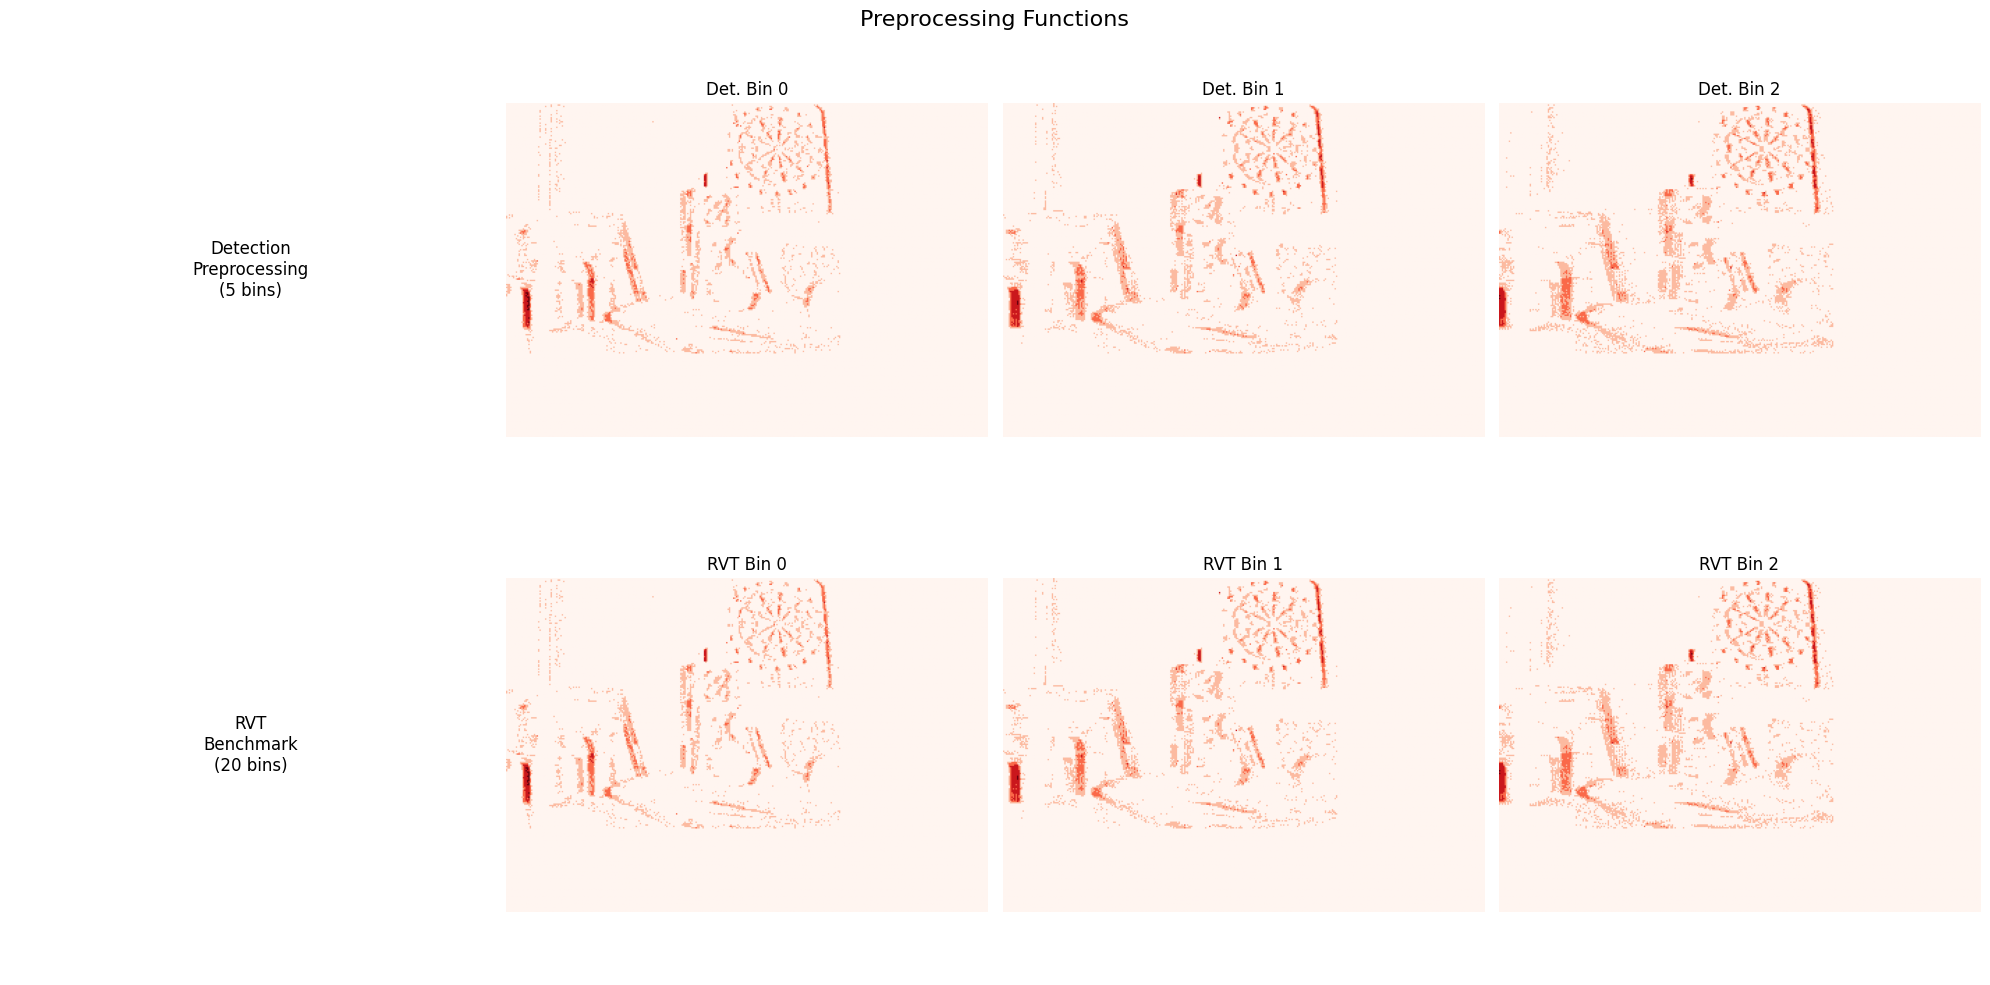

Preprocessing functions provide optimized representations for specific tasks:
- preprocess_for_detection: 5-bin stacked histogram for object detection
- benchmark_vs_rvt: 20-bin stacked histogram compatible with RVT models
Use case: Direct input to neural networks, standardized preprocessing


In [13]:
print("Creating Preprocessing Representations...")
start_time_rep = time.time()

# Preprocessing for detection (optimized stacked histogram)
detection_df = evr.preprocess_for_detection(
    events_window, HEIGHT, WIDTH, bins=5, engine=ENGINE
)

# Benchmark vs RVT (20-bin stacked histogram)
rvt_df = evr.benchmark_vs_rvt(
    events_window, HEIGHT, WIDTH, engine=ENGINE
)

creation_time = time.time() - start_time_rep
print(f"Creation time: {creation_time:.3f}s")
print(f"Detection preprocessing shape: {len(detection_df)} rows")
print(f"RVT benchmark shape: {len(rvt_df)} rows")

# Convert detection preprocessing to array (simplified - just show first few bins)
detection_pos, detection_neg = histogram_to_array(detection_df, HEIGHT, WIDTH, 5)
rvt_pos, rvt_neg = histogram_to_array(rvt_df, HEIGHT, WIDTH, 20)

# Visualize preprocessing functions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Preprocessing Functions', fontsize=16)

# Detection preprocessing (5 bins)
axes[0, 0].text(0.5, 0.5, 'Detection\nPreprocessing\n(5 bins)', 
                ha='center', va='center', transform=axes[0, 0].transAxes, fontsize=12)
axes[0, 0].axis('off')

for i in range(3):  # Show first 3 bins
    im = axes[0, i+1].imshow(detection_pos[i], cmap='Reds', vmin=0, vmax=detection_pos.max())
    axes[0, i+1].set_title(f'Det. Bin {i}')
    axes[0, i+1].axis('off')

# RVT benchmark (show first 4 out of 20 bins)
axes[1, 0].text(0.5, 0.5, 'RVT\nBenchmark\n(20 bins)', 
                ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
axes[1, 0].axis('off')

for i in range(3):  # Show first 3 bins
    im = axes[1, i+1].imshow(rvt_pos[i], cmap='Reds', vmin=0, vmax=rvt_pos.max())
    axes[1, i+1].set_title(f'RVT Bin {i}')
    axes[1, i+1].axis('off')

plt.tight_layout()
plt.show()

print("Preprocessing functions provide optimized representations for specific tasks:")
print("- preprocess_for_detection: 5-bin stacked histogram for object detection")
print("- benchmark_vs_rvt: 20-bin stacked histogram compatible with RVT models")
print("Use case: Direct input to neural networks, standardized preprocessing")

## 4. Comparative Analysis

Let's compare all representations side by side to understand their characteristics and appropriate use cases.

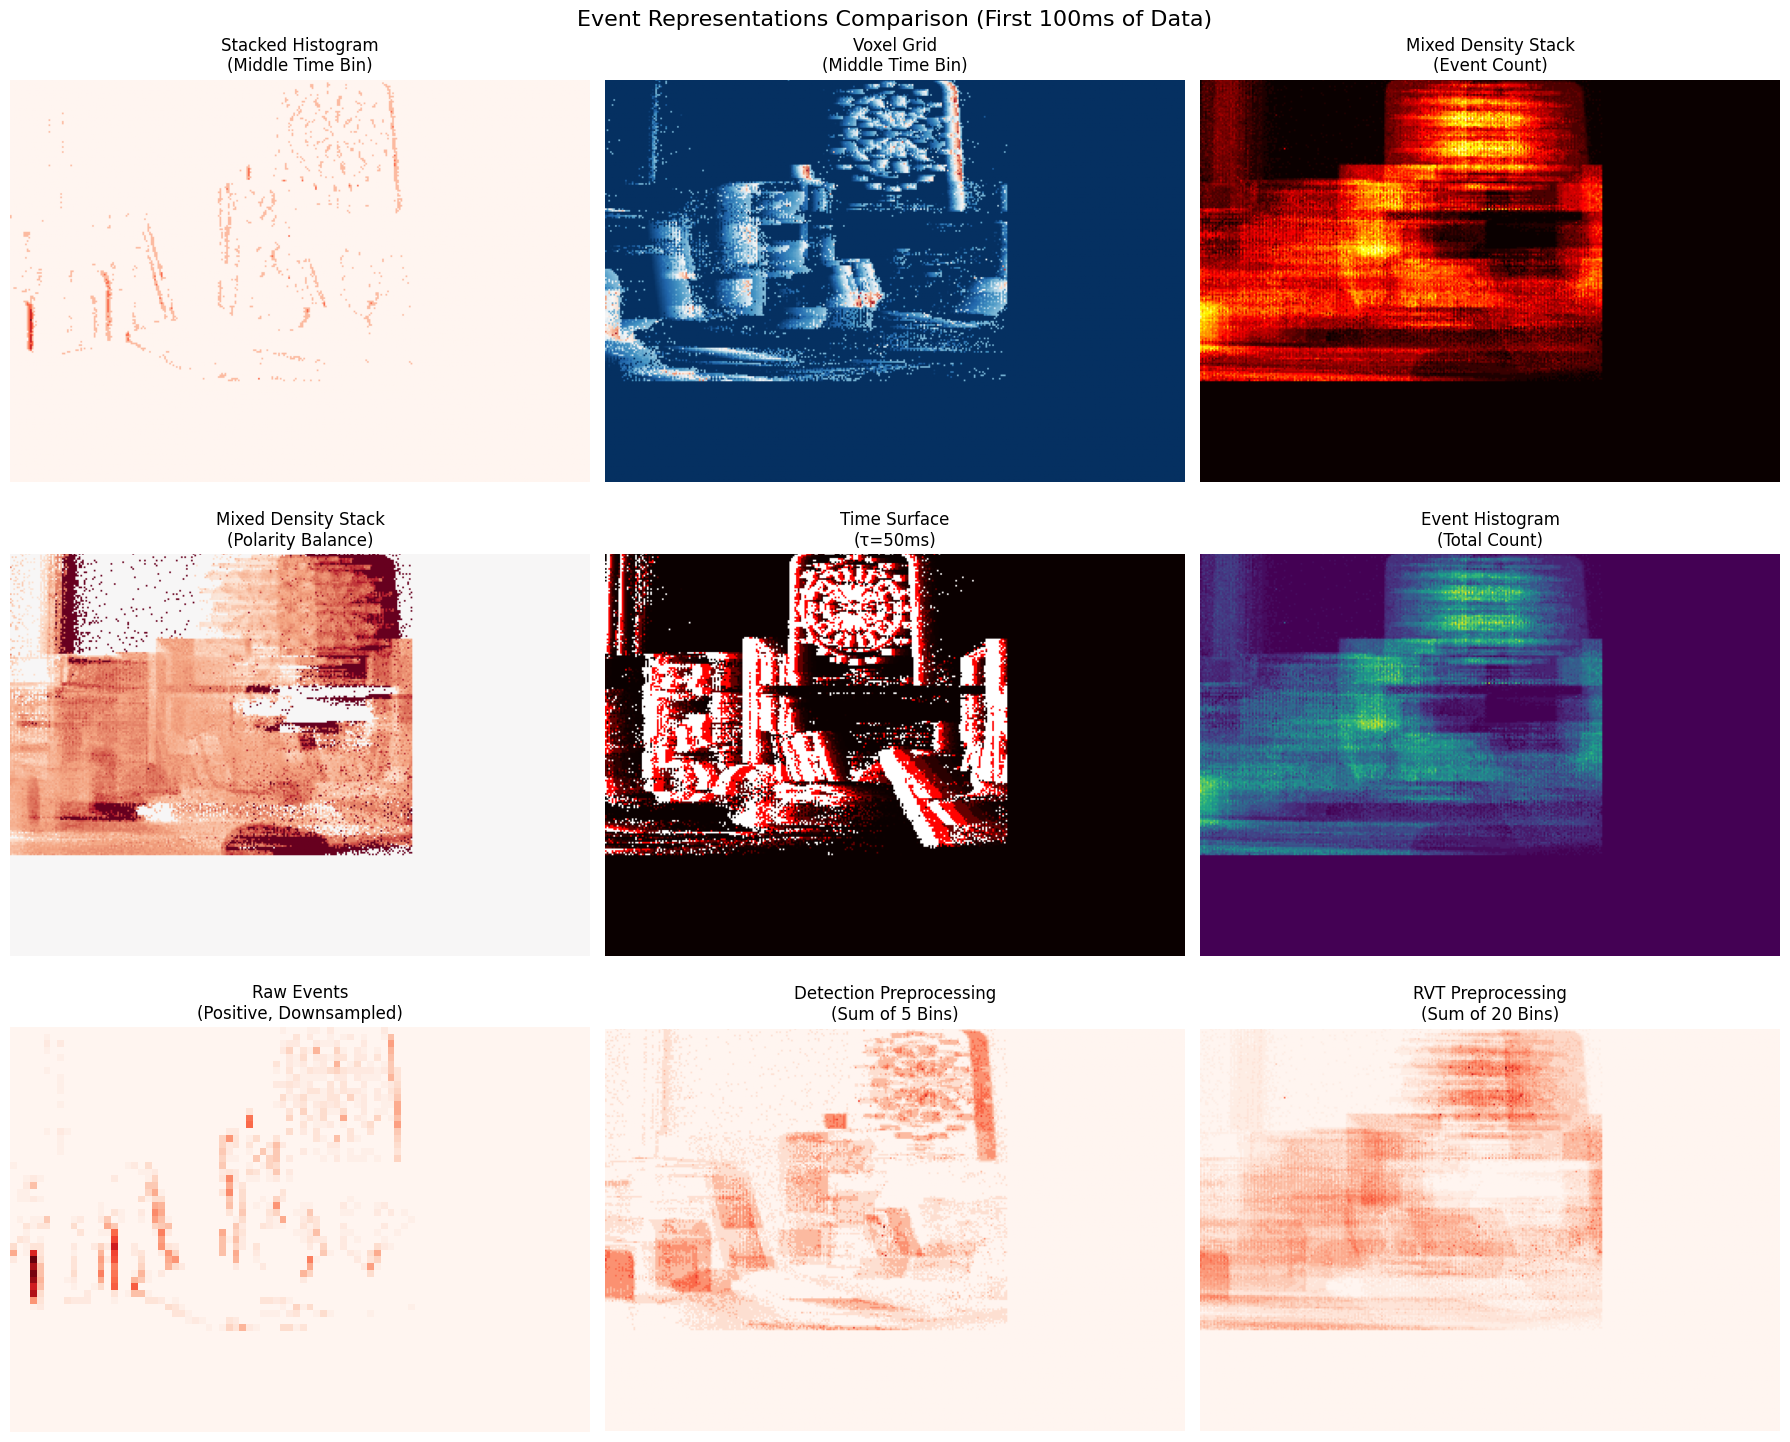

In [14]:
# Create comparison visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Event Representations Comparison (First 100ms of Data)', fontsize=16)

# Stacked histogram (middle time bin)
axes[0, 0].imshow(pos_hist_5[2], cmap='Reds')
axes[0, 0].set_title('Stacked Histogram\n(Middle Time Bin)')
axes[0, 0].axis('off')

# Voxel grid (middle time bin)
axes[0, 1].imshow(voxel_array[2], cmap='RdBu_r')
axes[0, 1].set_title('Voxel Grid\n(Middle Time Bin)')
axes[0, 1].axis('off')

# Mixed density - count
axes[0, 2].imshow(count_array, cmap='hot')
axes[0, 2].set_title('Mixed Density Stack\n(Event Count)')
axes[0, 2].axis('off')

# Mixed density - balance
axes[1, 0].imshow(balance_array, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 0].set_title('Mixed Density Stack\n(Polarity Balance)')
axes[1, 0].axis('off')

# Time surface
axes[1, 1].imshow(time_surface_combined, cmap='hot')
axes[1, 1].set_title('Time Surface\n(τ=50ms)')
axes[1, 1].axis('off')

# Event histogram
axes[1, 2].imshow(event_count_total, cmap='viridis')
axes[1, 2].set_title('Event Histogram\n(Total Count)')
axes[1, 2].axis('off')

# Raw events spatial
sample_spatial = events_window.head(5000).collect()
x_comp = sample_spatial["x"].to_numpy()
y_comp = sample_spatial["y"].to_numpy()
pol_comp = sample_spatial["polarity"].to_numpy()

# Create 2D histogram for comparison
hist_2d_pos, _, _ = np.histogram2d(y_comp[pol_comp==1], x_comp[pol_comp==1], 
                                  bins=[HEIGHT//4, WIDTH//4], 
                                  range=[[0, HEIGHT], [0, WIDTH]])
axes[2, 0].imshow(hist_2d_pos, cmap='Reds')
axes[2, 0].set_title('Raw Events\n(Positive, Downsampled)')
axes[2, 0].axis('off')

# Detection preprocessing (sum of all bins)
detection_sum = detection_pos.sum(axis=0)
axes[2, 1].imshow(detection_sum, cmap='Reds')
axes[2, 1].set_title('Detection Preprocessing\n(Sum of 5 Bins)')
axes[2, 1].axis('off')

# RVT preprocessing (sum of all bins)
rvt_sum = rvt_pos.sum(axis=0)
axes[2, 2].imshow(rvt_sum, cmap='Reds')
axes[2, 2].set_title('RVT Preprocessing\n(Sum of 20 Bins)')
axes[2, 2].axis('off')

plt.tight_layout()
plt.show()

### Representation Characteristics Summary

In [15]:
# Create characteristics comparison table
import pandas as pd

characteristics = {
    'Representation': [
        'Stacked Histogram',
        'Voxel Grid', 
        'Mixed Density Stack',
        'Time Surface',
        'Event Histogram',
        'Detection Preprocessing',
        'RVT Preprocessing'
    ],
    'Temporal Info': [
        'Discrete bins',
        'Smooth interpolation',
        'None',
        'Exponential decay',
        'None',
        'Discrete bins (5)',
        'Discrete bins (20)'
    ],
    'Polarity Handling': [
        'Separate channels',
        'Signed contributions',
        'Sum + count',
        'Separate surfaces',
        'Separate counts',
        'Separate channels',
        'Separate channels'
    ],
    'Memory Usage': [
        'Medium-High',
        'Medium',
        'Low',
        'Medium',
        'Low',
        'Medium',
        'High'
    ],
    'Best Use Case': [
        'Deep learning input',
        'Smooth temporal models',
        'Spatial analysis',
        'Activity detection',
        'Basic preprocessing',
        'Object detection',
        'RVT/Transformer models'
    ]
}

comparison_df = pd.DataFrame(characteristics)
print("Event Representations Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Performance metrics for the time window
print("\n\nPerformance Metrics (100ms window):")
print("=" * 50)
print(f"Input events: {n_events_window:,}")
print(f"Stacked histogram (5-bin): {len(hist_5_df):,} rows")
print(f"Voxel grid: {len(voxel_df):,} rows")
print(f"Mixed density: {len(mixed_df):,} rows")
print(f"Time surface: {len(time_surface_df):,} rows")
print(f"Event histogram: {len(event_hist_df):,} rows")
print(f"Detection preprocessing: {len(detection_df):,} rows")
print(f"RVT preprocessing: {len(rvt_df):,} rows")

Event Representations Comparison:
         Representation        Temporal Info    Polarity Handling Memory Usage          Best Use Case
      Stacked Histogram        Discrete bins    Separate channels  Medium-High    Deep learning input
             Voxel Grid Smooth interpolation Signed contributions       Medium Smooth temporal models
    Mixed Density Stack                 None          Sum + count          Low       Spatial analysis
           Time Surface    Exponential decay    Separate surfaces       Medium     Activity detection
        Event Histogram                 None      Separate counts          Low    Basic preprocessing
Detection Preprocessing    Discrete bins (5)    Separate channels       Medium       Object detection
      RVT Preprocessing   Discrete bins (20)    Separate channels         High RVT/Transformer models


Performance Metrics (100ms window):
Input events: 311,110
Stacked histogram (5-bin): 22,528 rows
Voxel grid: 311,108 rows
Mixed density: 37,818 rows

## 5. Performance Benchmarking

Let's benchmark the creation time and memory usage of different representations with varying data sizes.

In [16]:
# Benchmark different data sizes
import psutil
import gc

def benchmark_representation(func, events_data, *args, **kwargs):
    """Benchmark a representation function."""
    # Clear memory
    gc.collect()
    
    # Measure memory before
    process = psutil.Process()
    memory_before = process.memory_info().rss / 1024 / 1024  # MB
    
    # Time the function
    start_time = time.time()
    result = func(events_data, *args, **kwargs)
    end_time = time.time()
    
    # Measure memory after
    memory_after = process.memory_info().rss / 1024 / 1024  # MB
    
    return {
        'time': end_time - start_time,
        'memory_delta': memory_after - memory_before,
        'result_size': len(result)
    }

# Test with different time windows
time_windows = [0.01, 0.05, 0.1, 0.2]  # 10ms, 50ms, 100ms, 200ms
benchmark_results = []

print("Benchmarking representations with different data sizes...")
print("Time Window | Events | Stacked Hist | Voxel Grid | Mixed Density | Time Surface | Event Hist")
print("-" * 100)

for window_size in time_windows:
    # Create data subset
    window_end = start_time + window_size
    events_subset = events_lf.filter(
        pl.col("t").dt.total_seconds() <= window_end
    )
    
    n_events = events_subset.select(pl.len()).collect().item()
    
    # Skip if too few events
    if n_events < 100:
        continue
    
    # Benchmark each representation
    results = {}
    
    try:
        results['stacked'] = benchmark_representation(
            evr.create_stacked_histogram, events_subset, HEIGHT, WIDTH, 5, 10.0, ENGINE
        )
    except Exception as e:
        results['stacked'] = {'time': float('inf'), 'memory_delta': 0, 'result_size': 0}
    
    try:
        results['voxel'] = benchmark_representation(
            evr.create_voxel_grid, events_subset, HEIGHT, WIDTH, 5, ENGINE
        )
    except Exception as e:
        results['voxel'] = {'time': float('inf'), 'memory_delta': 0, 'result_size': 0}
    
    try:
        results['mixed'] = benchmark_representation(
            evr.create_mixed_density_stack, events_subset, HEIGHT, WIDTH, ENGINE
        )
    except Exception as e:
        results['mixed'] = {'time': float('inf'), 'memory_delta': 0, 'result_size': 0}
    
    try:
        results['surface'] = benchmark_representation(
            evr.time_surface, events_subset, HEIGHT, WIDTH, 50000.0, ENGINE
        )
    except Exception as e:
        results['surface'] = {'time': float('inf'), 'memory_delta': 0, 'result_size': 0}
    
    try:
        results['histogram'] = benchmark_representation(
            evr.event_histogram, events_subset, HEIGHT, WIDTH, ENGINE
        )
    except Exception as e:
        results['histogram'] = {'time': float('inf'), 'memory_delta': 0, 'result_size': 0}
    
    # Print results
    print(f"{window_size*1000:8.0f}ms | {n_events:6,} | "
          f"{results['stacked']['time']:9.3f}s | "
          f"{results['voxel']['time']:9.3f}s | "
          f"{results['mixed']['time']:10.3f}s | "
          f"{results['surface']['time']:9.3f}s | "
          f"{results['histogram']['time']:9.3f}s")
    
    benchmark_results.append({
        'window_ms': window_size * 1000,
        'n_events': n_events,
        **{f'{k}_time': v['time'] for k, v in results.items()},
        **{f'{k}_size': v['result_size'] for k, v in results.items()}
    })

print("\nBenchmarking complete!")

Benchmarking representations with different data sizes...
Time Window | Events | Stacked Hist | Voxel Grid | Mixed Density | Time Surface | Event Hist
----------------------------------------------------------------------------------------------------
      10ms | 311,110 |     0.004s |     0.003s |      0.005s |     0.006s |     0.005s
      50ms | 311,110 |     0.003s |     0.003s |      0.005s |     0.006s |     0.005s
     100ms | 311,110 |     0.003s |     0.003s |      0.004s |     0.005s |     0.004s
     200ms | 311,110 |     0.003s |     0.003s |      0.004s |     0.006s |     0.004s

Benchmarking complete!


### Visualize Performance Results

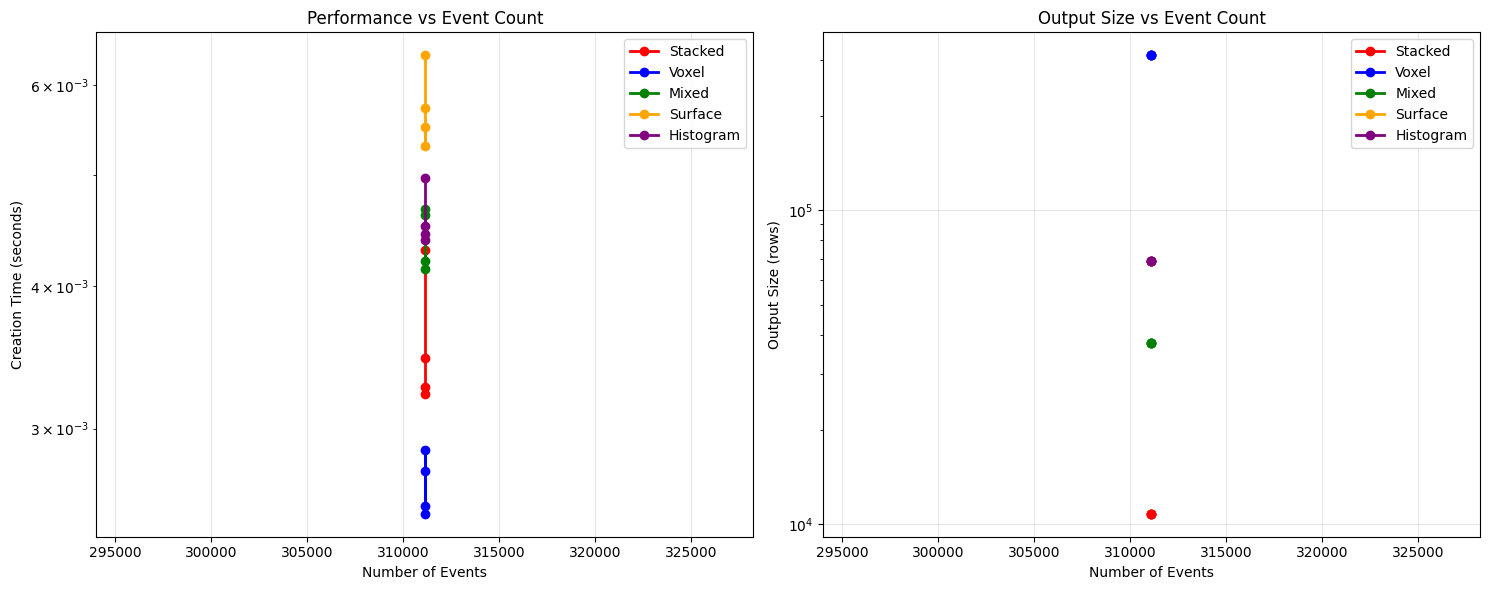

Performance Analysis:
- Stacked histograms scale with temporal bins
- Voxel grids have smooth scaling due to interpolation
- Mixed density and event histograms are most efficient
- Time surfaces scale with unique pixel locations


In [17]:
if benchmark_results:
    # Convert to DataFrame for easier plotting
    perf_df = pd.DataFrame(benchmark_results)
    
    # Plot performance vs event count
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Execution time vs events
    representations = ['stacked', 'voxel', 'mixed', 'surface', 'histogram']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for rep, color in zip(representations, colors):
        time_col = f'{rep}_time'
        if time_col in perf_df.columns:
            valid_times = perf_df[time_col] < float('inf')
            if valid_times.any():
                ax1.plot(perf_df.loc[valid_times, 'n_events'], 
                        perf_df.loc[valid_times, time_col], 
                        'o-', color=color, label=rep.title(), linewidth=2)
    
    ax1.set_xlabel('Number of Events')
    ax1.set_ylabel('Creation Time (seconds)')
    ax1.set_title('Performance vs Event Count')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Output size vs events
    for rep, color in zip(representations, colors):
        size_col = f'{rep}_size'
        if size_col in perf_df.columns:
            ax2.plot(perf_df['n_events'], perf_df[size_col], 
                    'o-', color=color, label=rep.title(), linewidth=2)
    
    ax2.set_xlabel('Number of Events')
    ax2.set_ylabel('Output Size (rows)')
    ax2.set_title('Output Size vs Event Count')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    print("Performance Analysis:")
    print("- Stacked histograms scale with temporal bins")
    print("- Voxel grids have smooth scaling due to interpolation")
    print("- Mixed density and event histograms are most efficient")
    print("- Time surfaces scale with unique pixel locations")
else:
    print("No benchmark results available")

## 6. Practical Applications

Let's demonstrate practical applications of each representation type.

### Application 1: Motion Detection with Time Surfaces

Motion Detection with Time Surfaces


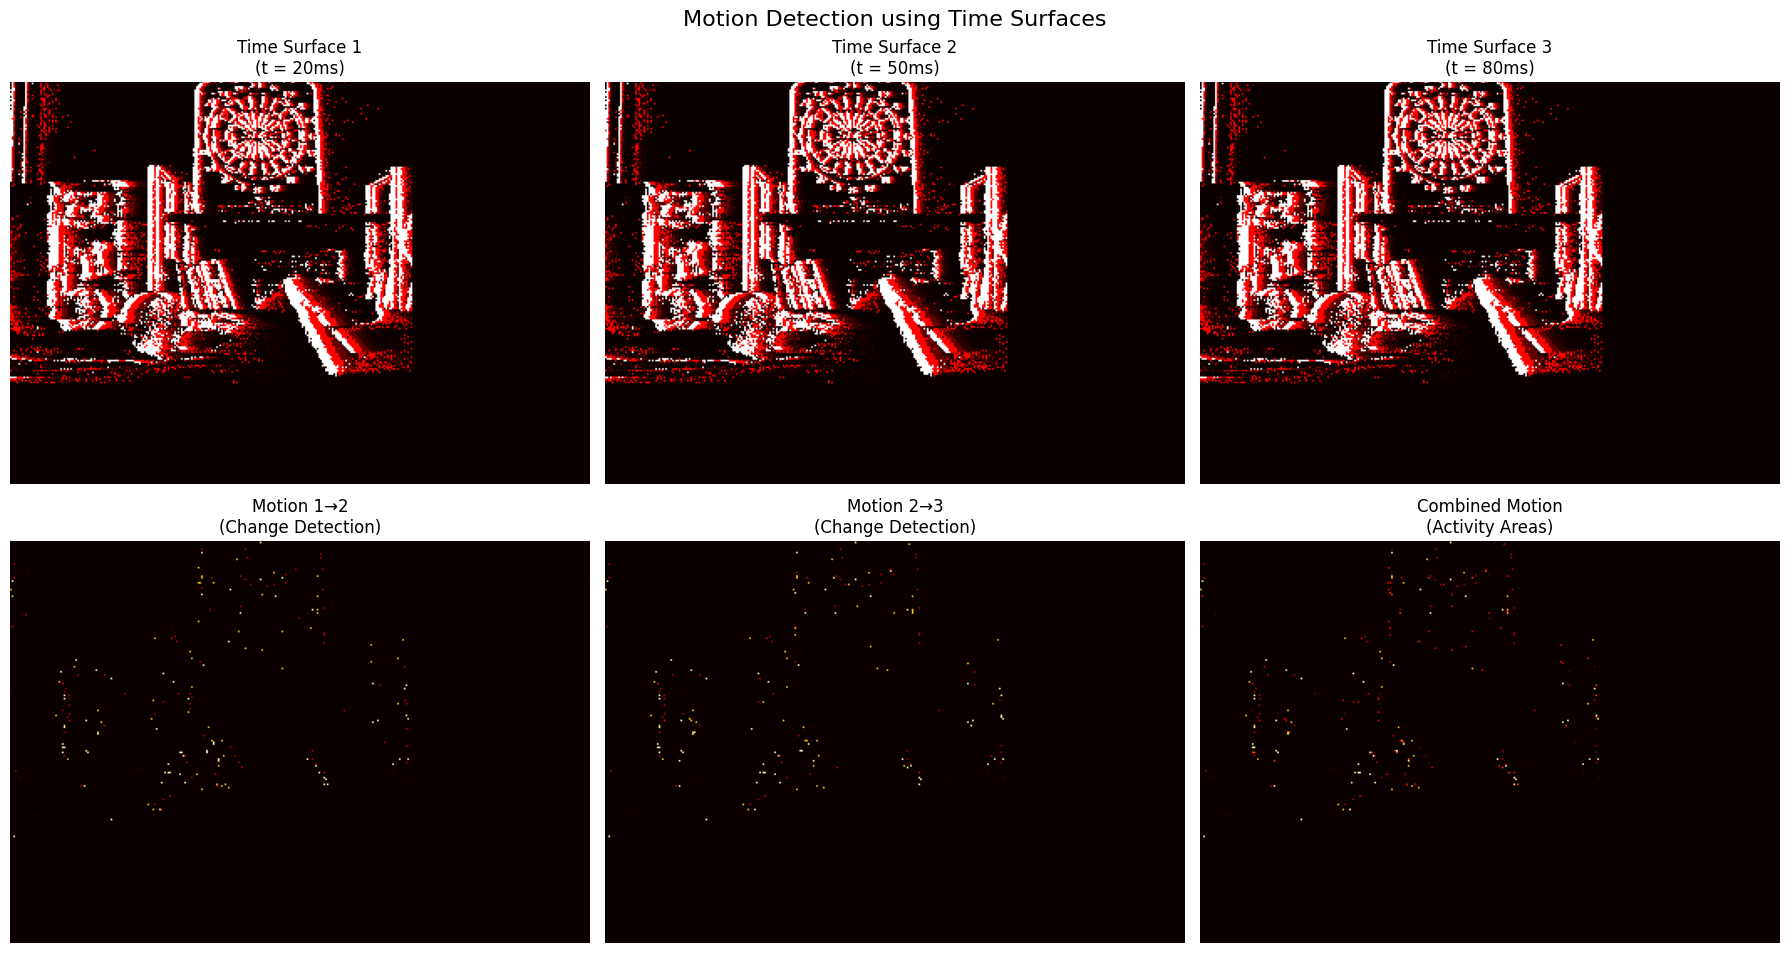

Time surfaces enable motion detection by tracking activity decay
Differences between time surfaces reveal changing activity patterns


In [18]:
print("Motion Detection with Time Surfaces")
print("=" * 40)

# Create time surfaces for different time windows to detect motion
motion_windows = [0.02, 0.05, 0.08]  # 20ms, 50ms, 80ms
motion_surfaces = []

for i, window_end in enumerate(motion_windows):
    window_events = events_lf.filter(
        pl.col("t").dt.total_seconds() <= start_time + window_end
    )
    
    surface_df = evr.time_surface(
        window_events, HEIGHT, WIDTH, tau=30000.0, engine=ENGINE  # 30ms decay
    )
    
    # Convert to array
    surface_array = np.zeros((HEIGHT, WIDTH))
    for row in surface_df.iter_rows(named=True):
        y, x = row['y'], row['x']
        if 0 <= y < HEIGHT and 0 <= x < WIDTH:
            surface_array[y, x] = max(surface_array[y, x], row['surface_value'])
    
    motion_surfaces.append(surface_array)

# Compute motion by taking differences between time surfaces
motion_1_2 = np.abs(motion_surfaces[1] - motion_surfaces[0])
motion_2_3 = np.abs(motion_surfaces[2] - motion_surfaces[1])

# Visualize motion detection
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Motion Detection using Time Surfaces', fontsize=16)

# Show time surfaces
for i, surface in enumerate(motion_surfaces):
    im = axes[0, i].imshow(surface, cmap='hot', vmin=0, vmax=1)
    axes[0, i].set_title(f'Time Surface {i+1}\n(t = {motion_windows[i]*1000:.0f}ms)')
    axes[0, i].axis('off')

# Show motion detection
axes[1, 0].imshow(motion_1_2, cmap='hot')
axes[1, 0].set_title('Motion 1→2\n(Change Detection)')
axes[1, 0].axis('off')

axes[1, 1].imshow(motion_2_3, cmap='hot')
axes[1, 1].set_title('Motion 2→3\n(Change Detection)')
axes[1, 1].axis('off')

# Combined motion
combined_motion = motion_1_2 + motion_2_3
axes[1, 2].imshow(combined_motion, cmap='hot')
axes[1, 2].set_title('Combined Motion\n(Activity Areas)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("Time surfaces enable motion detection by tracking activity decay")
print("Differences between time surfaces reveal changing activity patterns")

### Application 2: Feature Extraction with Stacked Histograms

Feature Extraction with Stacked Histograms


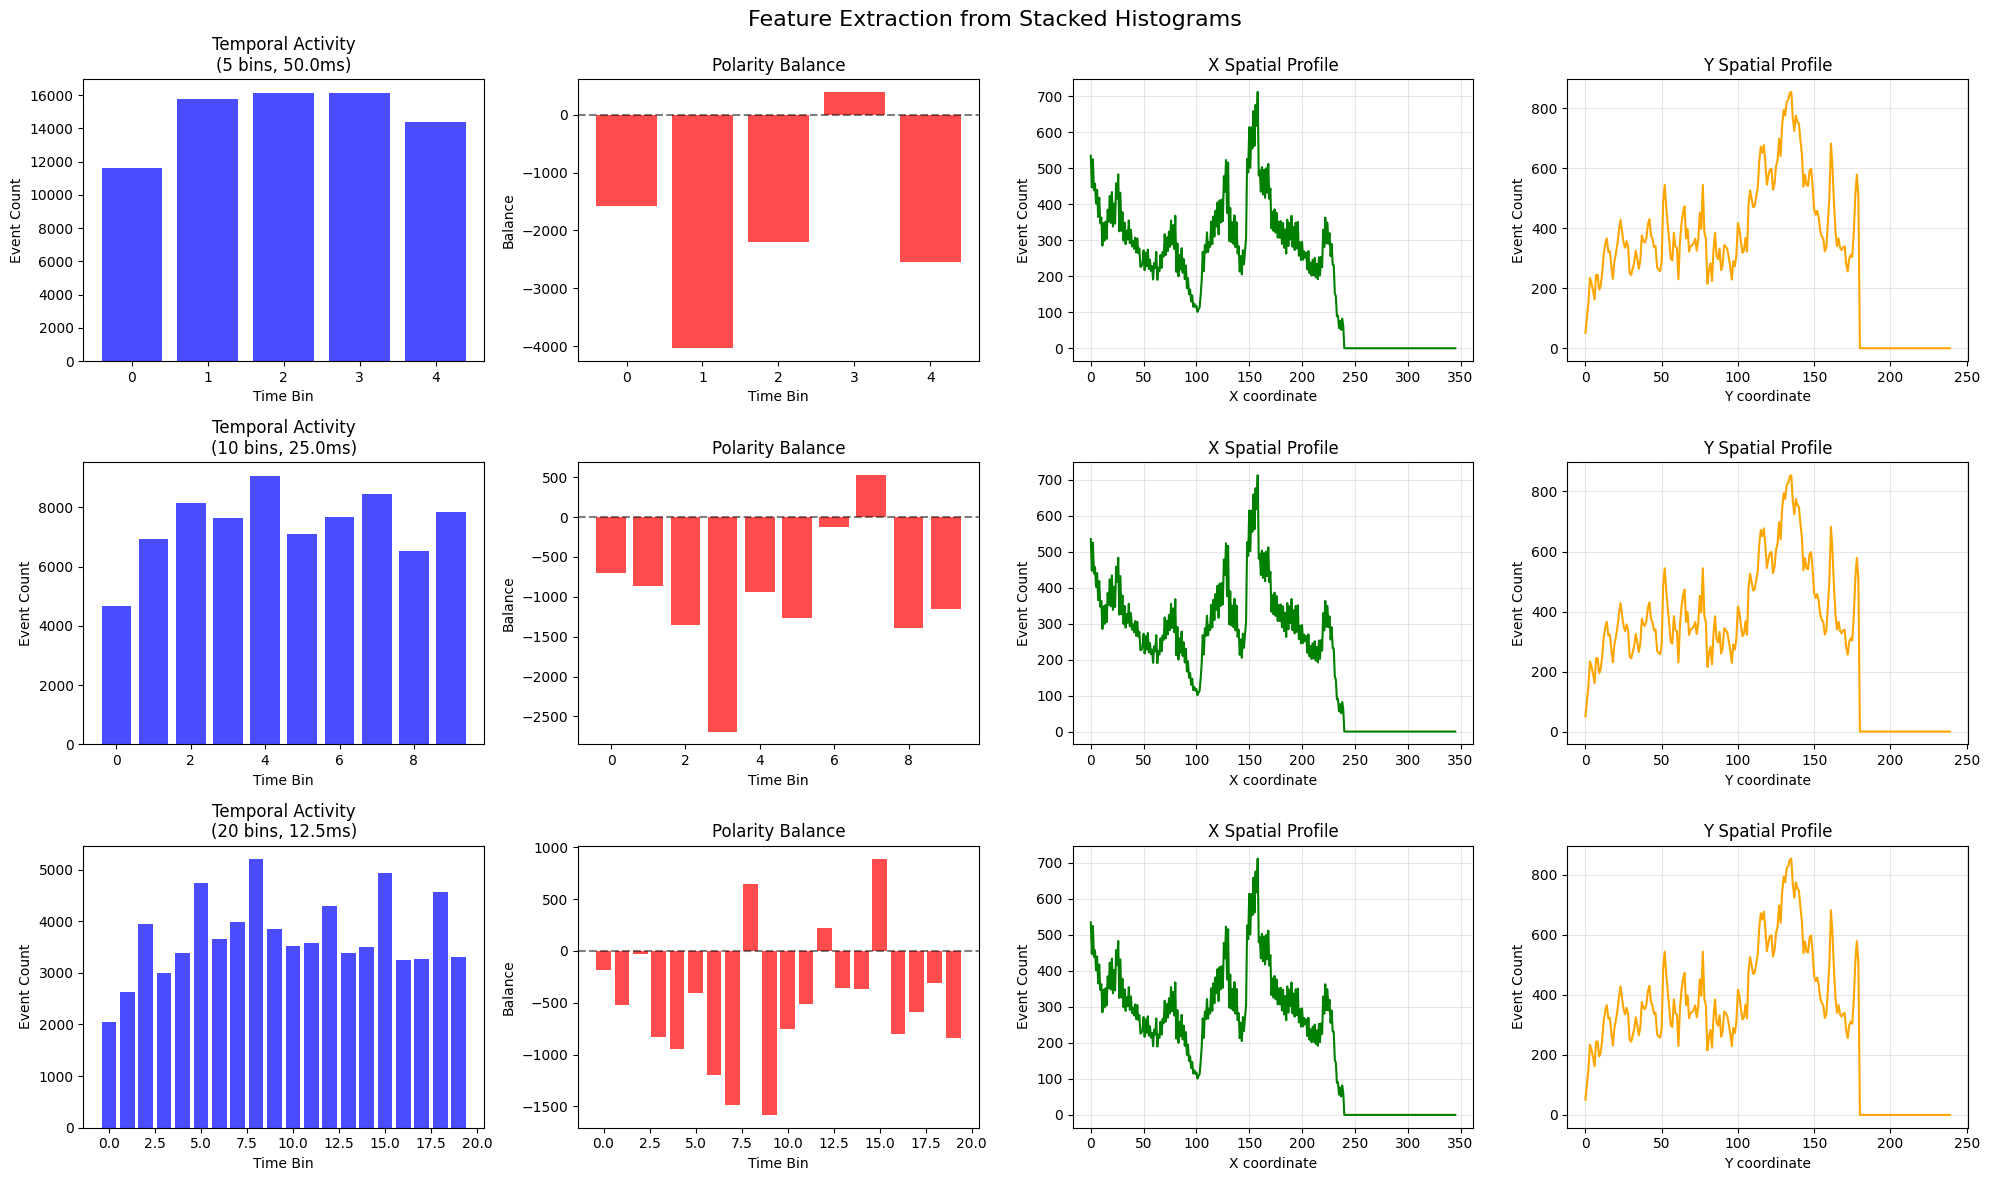

Stacked histograms enable multi-scale feature extraction:
- Temporal features: Activity patterns over time
- Spatial features: Spatial distribution patterns
- Polarity features: Balance between positive/negative events
- Multi-scale analysis reveals different temporal dynamics


In [19]:
print("Feature Extraction with Stacked Histograms")
print("=" * 42)

# Create multi-scale stacked histograms for feature extraction
scales = [(5, 50.0), (10, 25.0), (20, 12.5)]  # (bins, window_ms)
feature_histograms = []

for bins, window_ms in scales:
    hist_df = evr.create_stacked_histogram(
        events_window, HEIGHT, WIDTH, bins=bins, window_duration_ms=window_ms, engine=ENGINE
    )
    feature_histograms.append(hist_df)

# Convert to feature vectors (simplified - just spatial sums)
def extract_features(hist_df, height, width, bins):
    """Extract simple features from stacked histogram."""
    features = {
        'temporal_activity': np.zeros(bins),
        'spatial_activity_x': np.zeros(width),
        'spatial_activity_y': np.zeros(height),
        'polarity_balance': np.zeros(bins)
    }
    
    for row in hist_df.iter_rows(named=True):
        time_bin = row['time_bin']
        x, y = row['x'], row['y']
        count = row['count']
        polarity = row['polarity']
        
        if 0 <= time_bin < bins:
            features['temporal_activity'][time_bin] += count
            if polarity == 1:
                features['polarity_balance'][time_bin] += count
            else:
                features['polarity_balance'][time_bin] -= count
        
        if 0 <= x < width:
            features['spatial_activity_x'][x] += count
        if 0 <= y < height:
            features['spatial_activity_y'][y] += count
    
    return features

# Extract features for different scales
all_features = []
for i, (hist_df, (bins, window_ms)) in enumerate(zip(feature_histograms, scales)):
    features = extract_features(hist_df, HEIGHT, WIDTH, bins)
    all_features.append(features)

# Visualize features
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.suptitle('Feature Extraction from Stacked Histograms', fontsize=16)

for i, (features, (bins, window_ms)) in enumerate(zip(all_features, scales)):
    # Temporal activity
    axes[i, 0].bar(range(bins), features['temporal_activity'], color='blue', alpha=0.7)
    axes[i, 0].set_title(f'Temporal Activity\n({bins} bins, {window_ms}ms)')
    axes[i, 0].set_xlabel('Time Bin')
    axes[i, 0].set_ylabel('Event Count')
    
    # Polarity balance
    axes[i, 1].bar(range(bins), features['polarity_balance'], color='red', alpha=0.7)
    axes[i, 1].set_title('Polarity Balance')
    axes[i, 1].set_xlabel('Time Bin')
    axes[i, 1].set_ylabel('Balance')
    axes[i, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Spatial activity X
    x_activity = features['spatial_activity_x']
    axes[i, 2].plot(x_activity, color='green', linewidth=1.5)
    axes[i, 2].set_title('X Spatial Profile')
    axes[i, 2].set_xlabel('X coordinate')
    axes[i, 2].set_ylabel('Event Count')
    axes[i, 2].grid(True, alpha=0.3)
    
    # Spatial activity Y
    y_activity = features['spatial_activity_y']
    axes[i, 3].plot(y_activity, color='orange', linewidth=1.5)
    axes[i, 3].set_title('Y Spatial Profile')
    axes[i, 3].set_xlabel('Y coordinate')
    axes[i, 3].set_ylabel('Event Count')
    axes[i, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Stacked histograms enable multi-scale feature extraction:")
print("- Temporal features: Activity patterns over time")
print("- Spatial features: Spatial distribution patterns")
print("- Polarity features: Balance between positive/negative events")
print("- Multi-scale analysis reveals different temporal dynamics")

### Application 3: Noise Filtering with Mixed Density

Noise Filtering with Mixed Density Stack
Noise Analysis Results:
Total active pixels: 37,818
Low activity noise: 4,756 (12.6%)
High imbalance noise: 3,536 (9.4%)
Total noise pixels: 5,901 (15.6%)
Remaining valid pixels: 31,917 (84.4%)


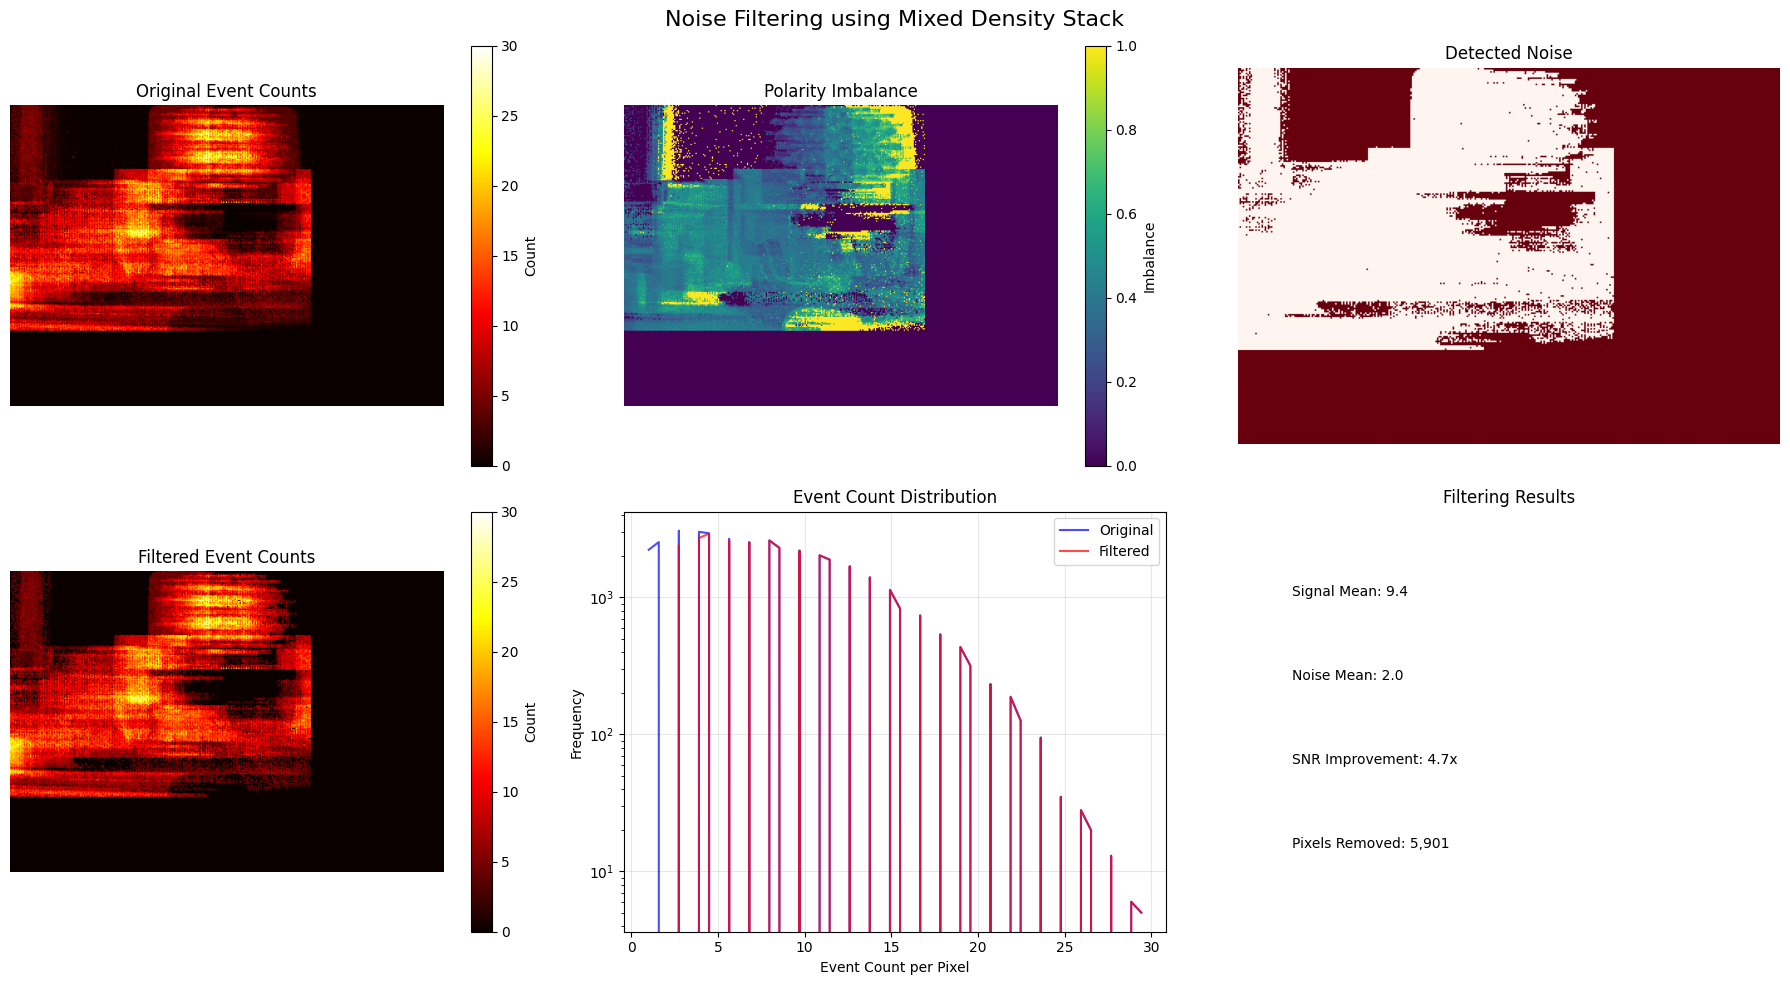

Mixed density stacks enable effective noise filtering by:
- Identifying pixels with too few events (likely noise)
- Detecting pixels with extreme polarity imbalance (sensor noise)
- Preserving pixels with balanced, sufficient activity (true signal)


In [20]:
print("Noise Filtering with Mixed Density Stack")
print("=" * 39)

# Use mixed density to identify and filter noisy pixels
# Noise typically appears as isolated pixels with few events

# Create mixed density for noise analysis
noise_analysis_df = evr.create_mixed_density_stack(
    events_window, HEIGHT, WIDTH, engine=ENGINE
)

# Extract statistics for noise filtering
event_counts = np.zeros((HEIGHT, WIDTH))
polarity_sums = np.zeros((HEIGHT, WIDTH))

for row in noise_analysis_df.iter_rows(named=True):
    y, x = row['y'], row['x']
    if 0 <= y < HEIGHT and 0 <= x < WIDTH:
        event_counts[y, x] = row['count']
        polarity_sums[y, x] = row['polarity_sum']

# Noise filtering criteria
min_events = 3  # Minimum events for valid pixel
max_imbalance = 0.8  # Maximum polarity imbalance (0-1)

# Calculate polarity balance
polarity_balance = np.zeros_like(polarity_sums)
mask = event_counts > 0
polarity_balance[mask] = np.abs(polarity_sums[mask]) / event_counts[mask]

# Create noise masks
noise_low_activity = event_counts < min_events
noise_high_imbalance = polarity_balance > max_imbalance
noise_combined = noise_low_activity | noise_high_imbalance

# Create filtered version
filtered_counts = event_counts.copy()
filtered_counts[noise_combined] = 0

# Statistics
total_active_pixels = np.sum(event_counts > 0)
noise_pixels_activity = np.sum(noise_low_activity & (event_counts > 0))
noise_pixels_imbalance = np.sum(noise_high_imbalance & (event_counts > 0))
noise_pixels_total = np.sum(noise_combined & (event_counts > 0))
remaining_pixels = np.sum(filtered_counts > 0)

print(f"Noise Analysis Results:")
print(f"Total active pixels: {total_active_pixels:,}")
print(f"Low activity noise: {noise_pixels_activity:,} ({noise_pixels_activity/total_active_pixels*100:.1f}%)")
print(f"High imbalance noise: {noise_pixels_imbalance:,} ({noise_pixels_imbalance/total_active_pixels*100:.1f}%)")
print(f"Total noise pixels: {noise_pixels_total:,} ({noise_pixels_total/total_active_pixels*100:.1f}%)")
print(f"Remaining valid pixels: {remaining_pixels:,} ({remaining_pixels/total_active_pixels*100:.1f}%)")

# Visualize noise filtering
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Noise Filtering using Mixed Density Stack', fontsize=16)

# Original event counts
im1 = axes[0, 0].imshow(event_counts, cmap='hot')
axes[0, 0].set_title('Original Event Counts')
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], label='Count')

# Polarity balance
im2 = axes[0, 1].imshow(polarity_balance, cmap='viridis', vmin=0, vmax=1)
axes[0, 1].set_title('Polarity Imbalance')
axes[0, 1].axis('off')
plt.colorbar(im2, ax=axes[0, 1], label='Imbalance')

# Noise mask
axes[0, 2].imshow(noise_combined, cmap='Reds')
axes[0, 2].set_title('Detected Noise')
axes[0, 2].axis('off')

# Filtered result
im3 = axes[1, 0].imshow(filtered_counts, cmap='hot')
axes[1, 0].set_title('Filtered Event Counts')
axes[1, 0].axis('off')
plt.colorbar(im3, ax=axes[1, 0], label='Count')

# Comparison histograms
original_hist, bins = np.histogram(event_counts[event_counts > 0], bins=50)
filtered_hist, _ = np.histogram(filtered_counts[filtered_counts > 0], bins=bins)

axes[1, 1].semilogy(bins[:-1], original_hist, 'b-', label='Original', alpha=0.7)
axes[1, 1].semilogy(bins[:-1], filtered_hist, 'r-', label='Filtered', alpha=0.7)
axes[1, 1].set_xlabel('Event Count per Pixel')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Event Count Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# SNR improvement estimate
signal_pixels = filtered_counts > 0
if np.sum(signal_pixels) > 0:
    signal_mean = np.mean(filtered_counts[signal_pixels])
    noise_mean = np.mean(event_counts[noise_combined & (event_counts > 0)]) if np.sum(noise_combined & (event_counts > 0)) > 0 else 0
    snr_improvement = signal_mean / noise_mean if noise_mean > 0 else float('inf')
    
    axes[1, 2].text(0.1, 0.8, f'Signal Mean: {signal_mean:.1f}', transform=axes[1, 2].transAxes)
    axes[1, 2].text(0.1, 0.6, f'Noise Mean: {noise_mean:.1f}', transform=axes[1, 2].transAxes)
    axes[1, 2].text(0.1, 0.4, f'SNR Improvement: {snr_improvement:.1f}x', transform=axes[1, 2].transAxes)
    axes[1, 2].text(0.1, 0.2, f'Pixels Removed: {noise_pixels_total:,}', transform=axes[1, 2].transAxes)
    axes[1, 2].set_title('Filtering Results')
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("Mixed density stacks enable effective noise filtering by:")
print("- Identifying pixels with too few events (likely noise)")
print("- Detecting pixels with extreme polarity imbalance (sensor noise)")
print("- Preserving pixels with balanced, sufficient activity (true signal)")